# Applied Data Analysis: Movies
This project analyzes the key factors influencing box-office success for films released between 1915 and 2015, seeking to understand how audience preferences and industry trends have evolved over time.

We will work with two datasets:
- CMU Movie Summary
- IMDb dataset

## Loading the Datasets

In [431]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
import os
import sys
import plotly.graph_objects as go

from importlib import reload
import src.utils.utils
reload(src.utils.utils)
from src.utils.utils import top_n_by_interval, top_n_total_revenue, top_n_average_rating

In [432]:
data_folder = './data/'
pickle_folder = data_folder + 'pickle/'
imdb_folder = data_folder + 'IMDB/'
cmu_folder = data_folder + 'CMU/'

# Modeling

In [433]:
import statsmodels.api as sm
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Training model on complete dataframe without seasons

In [721]:
with open(pickle_folder+"movies_clean.p", 'rb') as f:
    movies_clean = pickle.load(f)
with open(pickle_folder+"characters_clean.p", 'rb') as f:
    characters_clean = pickle.load(f)

In [722]:
periods = sorted(movies_clean["Year_Interval"].unique())
periods

['1915-1930', '1930-1950', '1950-1970', '1970-2000', '2000-2015']

In [723]:
def top_10_(df,feature):
    # top 30 rated movies
    top30_ = df.sort_values(by="averageRating",ascending=False).head(30)
    
    top10 = top30_[[x for x in top30_.columns if x.startswith(feature)]].sum(axis=0).sort_values(ascending=False).head(10)
    return top10

In [724]:
def corr_matrix_top_(period,df,feature):
    top_ = top_15_(df,feature)
    
    correlation_matrix=top_[[x for x in top_.columns if x.startswith(feature)]].corr().dropna(how='all').dropna(axis=1,how='all')
    print(correlation_matrix.shape)
    # Optionally, you can visualize the correlation matrix using a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix of {feature} in {period}')
    plt.show()

In [725]:
def plot_feature_importance(period,df,feature):
    # Define features and target
    X = df[[x for x in df.columns if x.startswith(feature)]]
    y = df['averageRating']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Train an XGBoost model
    xgb = XGBRegressor(random_state=42)
    xgb.fit(X_train, y_train)
    
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb.feature_importances_}).sort_values(by='Importance', ascending=False)
    
    # Plot the feature importance for the model
    plt.figure(figsize=(10, 15))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.title(f'{feature} Importance in {period}')
    plt.xlabel('Importance')
    plt.ylabel(f'{feature}')
    plt.show()

In [726]:
def plot_mean_per_year_(period,df,feature):
    mean_age_per_year = df.groupby('Year')[feature].mean()
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(mean_age_per_year.index, mean_age_per_year.values, marker='o', linestyle='-', color='b', label=f'Mean {feature}')
    plt.title(f'Mean {feature} ({period})', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'Mean {feature}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

# 1915 - 1930 (Silent Films)

/var/folders/gc/k740v3612cv_1m5s2d93wxzr0000gn/T/ipykernel_46362/3549104300.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



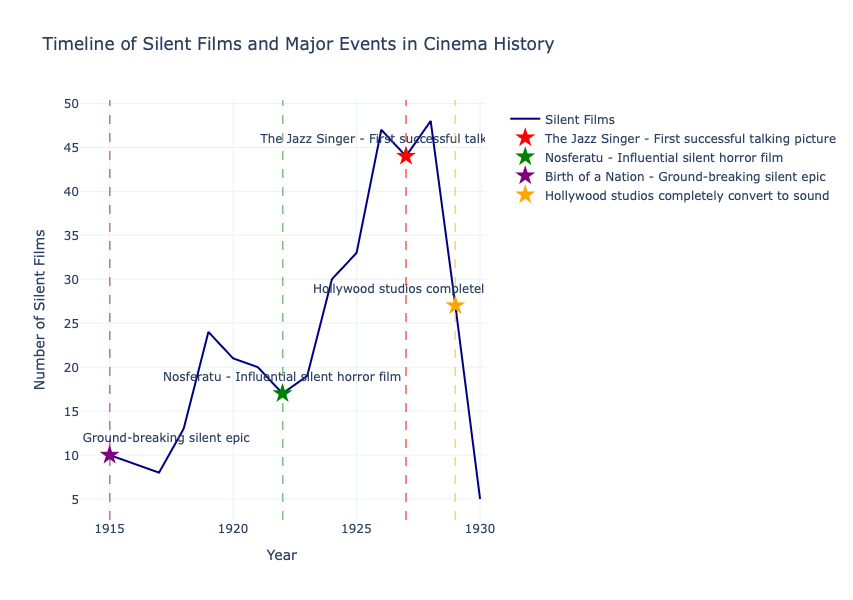

In [748]:
period0 = periods[0]
df_period0 = movies_clean[movies_clean["Year_Interval"] == period0]

df = pd.DataFrame(df_period0[df_period0["Genre_Silent film"]==True].groupby("Year").apply(lambda x: x["Genre_Silent film"].sum()),columns=["count"]).reset_index()

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming your DataFrame is called 'df' with columns 'year' and 'silent_films'

# Create the events data
events = {
    1927: {'text': 'The Jazz Singer - First successful talking picture', 'color': 'red'},
    1922: {'text': 'Nosferatu - Influential silent horror film', 'color': 'green'},
    1915: {'text': 'Birth of a Nation - Ground-breaking silent epic', 'color': 'purple'},
    1929: {'text': 'Hollywood studios completely convert to sound', 'color': 'orange'}
}

# Create the main line plot
fig = go.Figure()

# Add the silent films line
fig.add_trace(
    go.Scatter(
        x=df['Year'],
        y=df['count'],
        mode='lines',
        name='Silent Films',
        line=dict(color='navy', width=2)
    )
)

# Add event markers
for year, event in events.items():
    fig.add_trace(
        go.Scatter(
            x=[year],
            y=[df[df['Year'] == year]['count'].values[0]],
            mode='markers+text',
            name=event['text'],
            marker=dict(
                symbol='star',
                size=15,
                color=event['color']
            ),
            text=event['text'],
            textposition='top center',
            hoverinfo='text+x+y',
            showlegend=True
        )
    )

# Add vertical lines for events
for year, event in events.items():
    fig.add_vline(
        x=year,
        line_dash="dash",
        line_color=event['color'],
        opacity=0.5
    )

# Update layout
fig.update_layout(
    title='Timeline of Silent Films and Major Events in Cinema History',
    xaxis_title='Year',
    yaxis_title='Number of Silent Films',
    hovermode='closest',
    template='plotly_white',
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=1.05
    ),
    margin=dict(r=200)  # Add right margin for legend
)

# Make it responsive
fig.update_layout(
    autosize=True,
    width=1000,
    height=600
)

# Show the plot
fig.show()

Top 10 most frequent genres in the 30 highest-rated movies :


Genre_Drama              27
Genre_Black-and-white    27
Genre_Silent film        26
Genre_Indie              21
Genre_Other              15
Genre_Comedy              9
Genre_World cinema        8
Genre_Romance Film        8
Genre_War film            7
Genre_Romantic comedy     5
dtype: int64

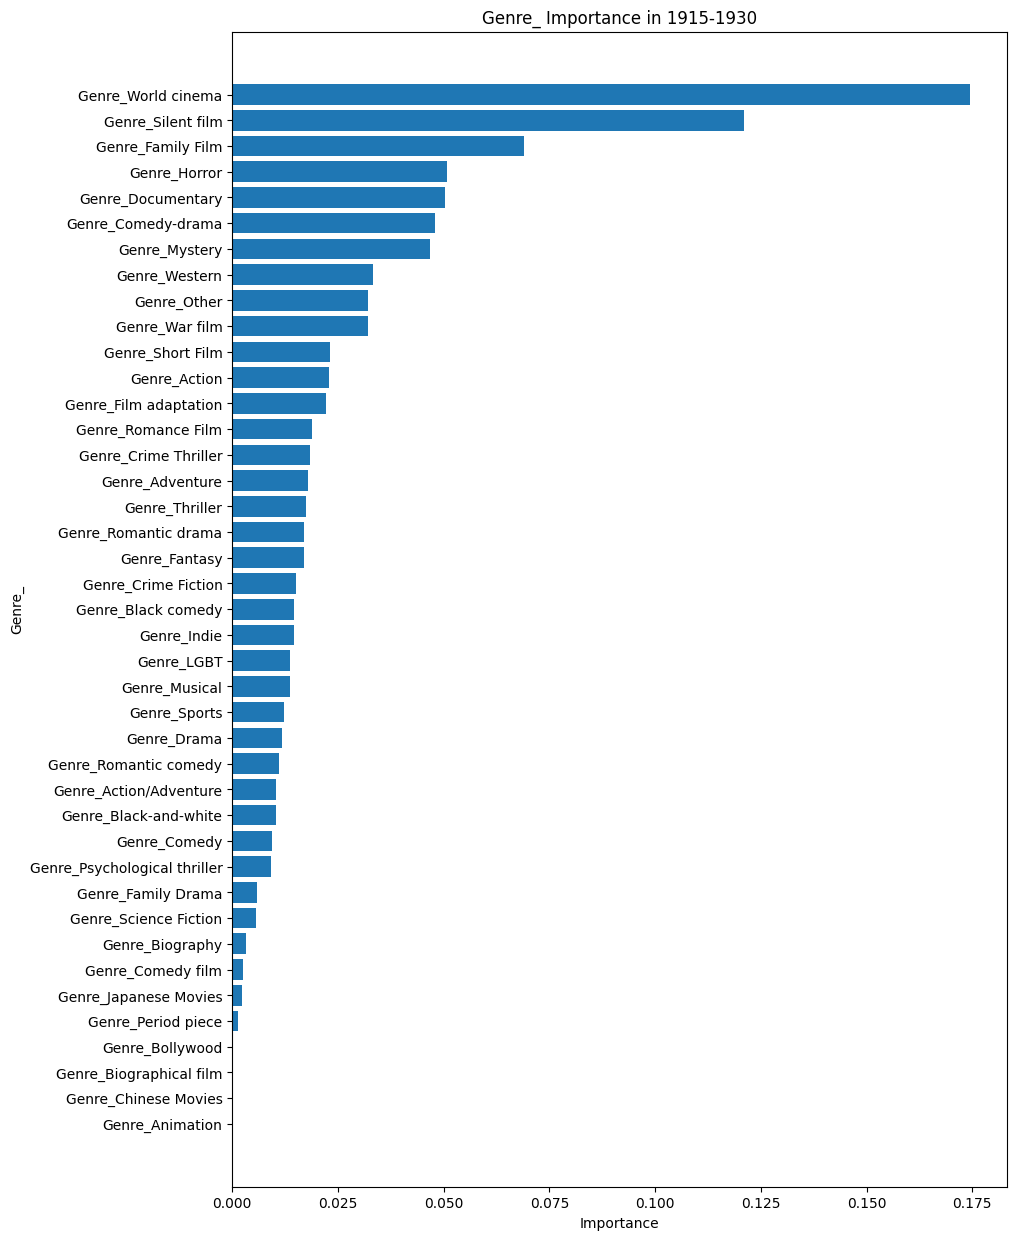

(23, 23)


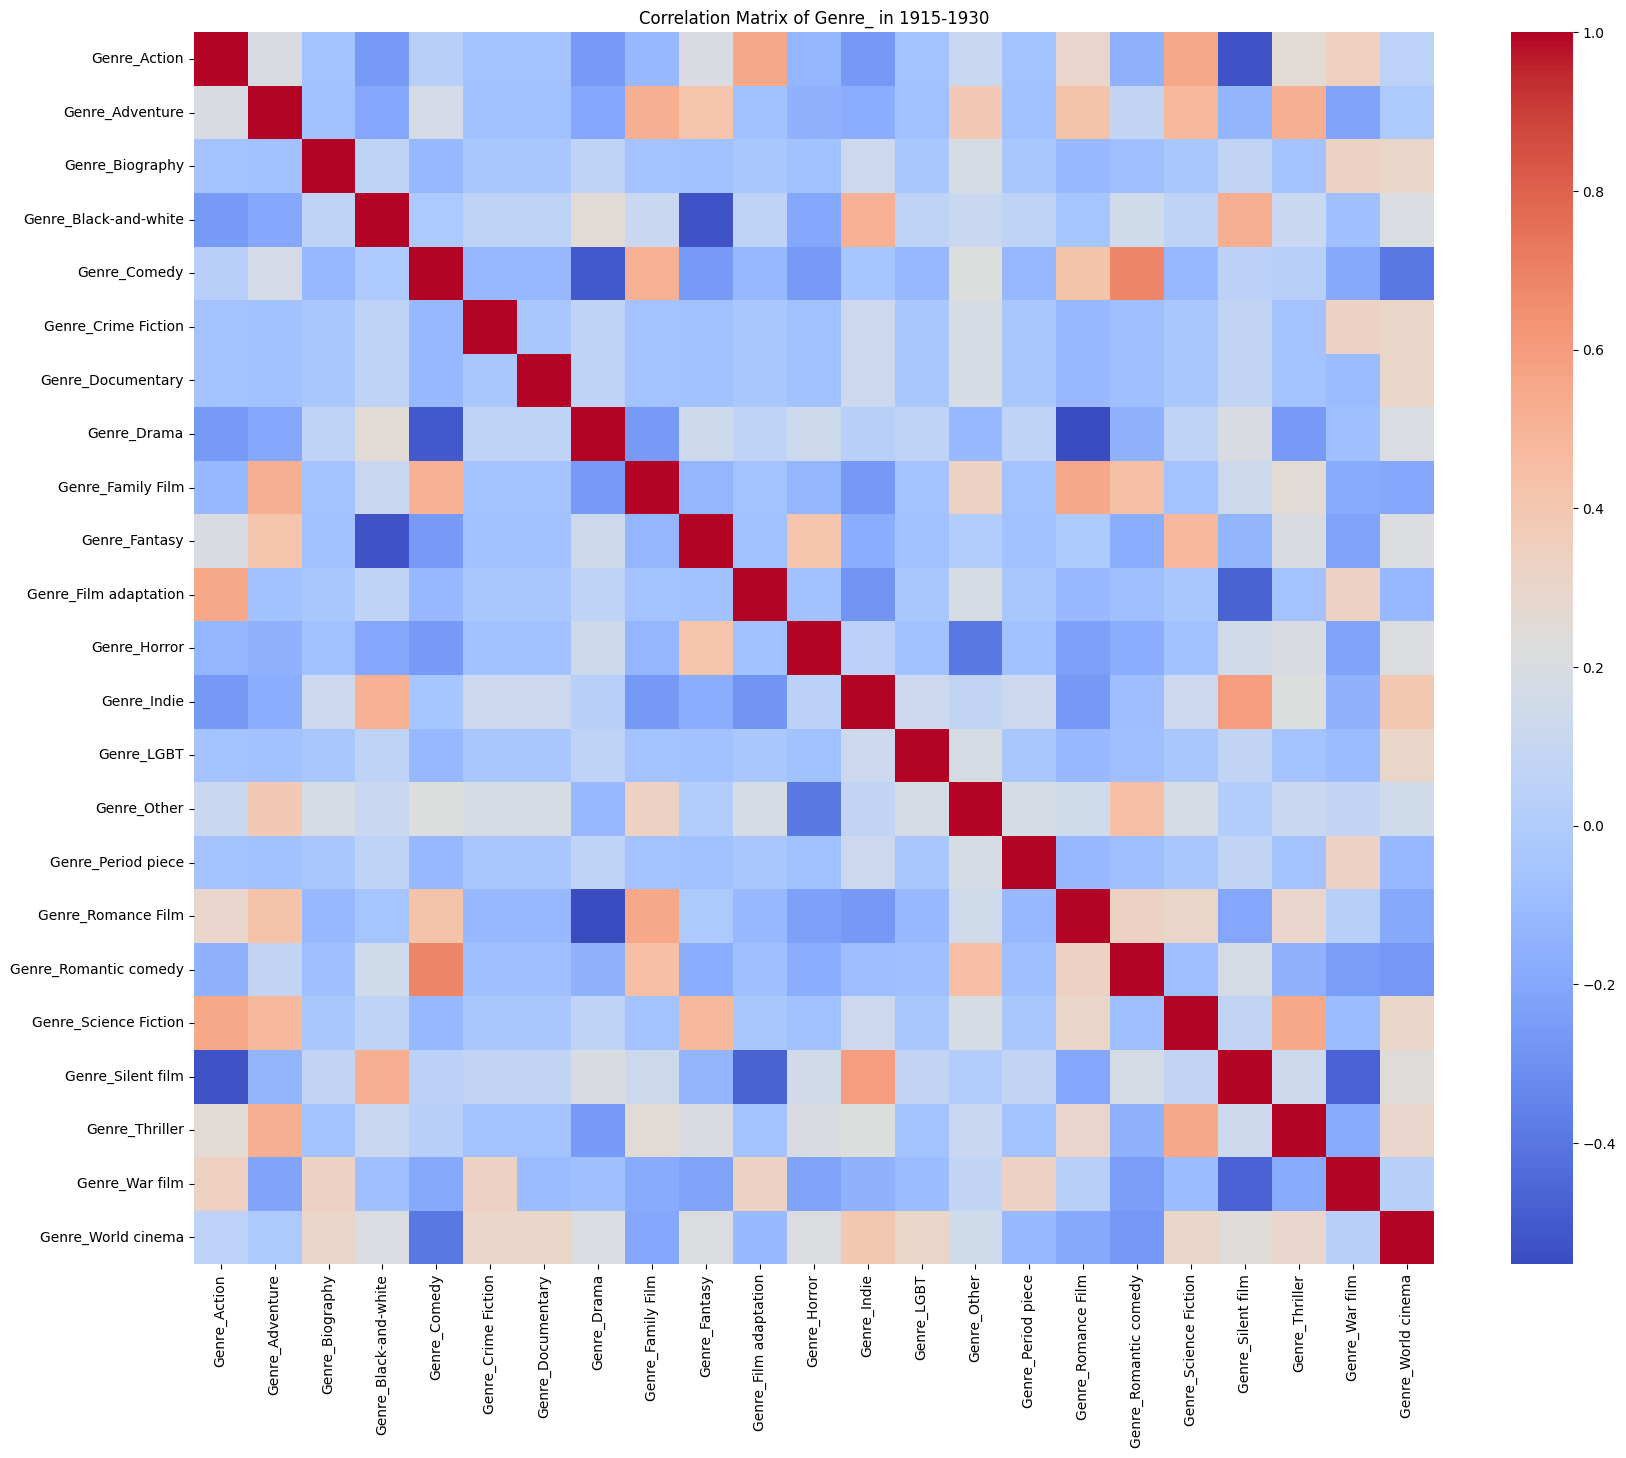

In [696]:
# Silent films compose the major part of this period. However, with the thanks to the apparition of the 
# first "talkies" and sound in cinema, there is the emergence of established genres like Drama, comedy 
# or musical.
# The World Cinema genre is highly rated during 1915-1930 due to groundbreaking innovations and especially 
# the rise of talkies, which transformed storytelling, and the emergence of unique cinematic styles.

print("Top 10 most frequent genres in the 30 highest-rated movies :")
display(top_10_(df_period0,'Genre_'))
plot_feature_importance(period0,df_period0,'Genre_')
corr_matrix_top_(period0,df_period0,'Genre_')

Top 10 most frequent Countries in the 30 highest-rated movies :


Country_United States of America    20
Country_Other                        8
Country_Germany                      7
Country_France                       1
Country_Argentina                    0
Country_Canada                       0
Country_Hong Kong                    0
Country_India                        0
Country_Italy                        0
Country_Japan                        0
dtype: int64

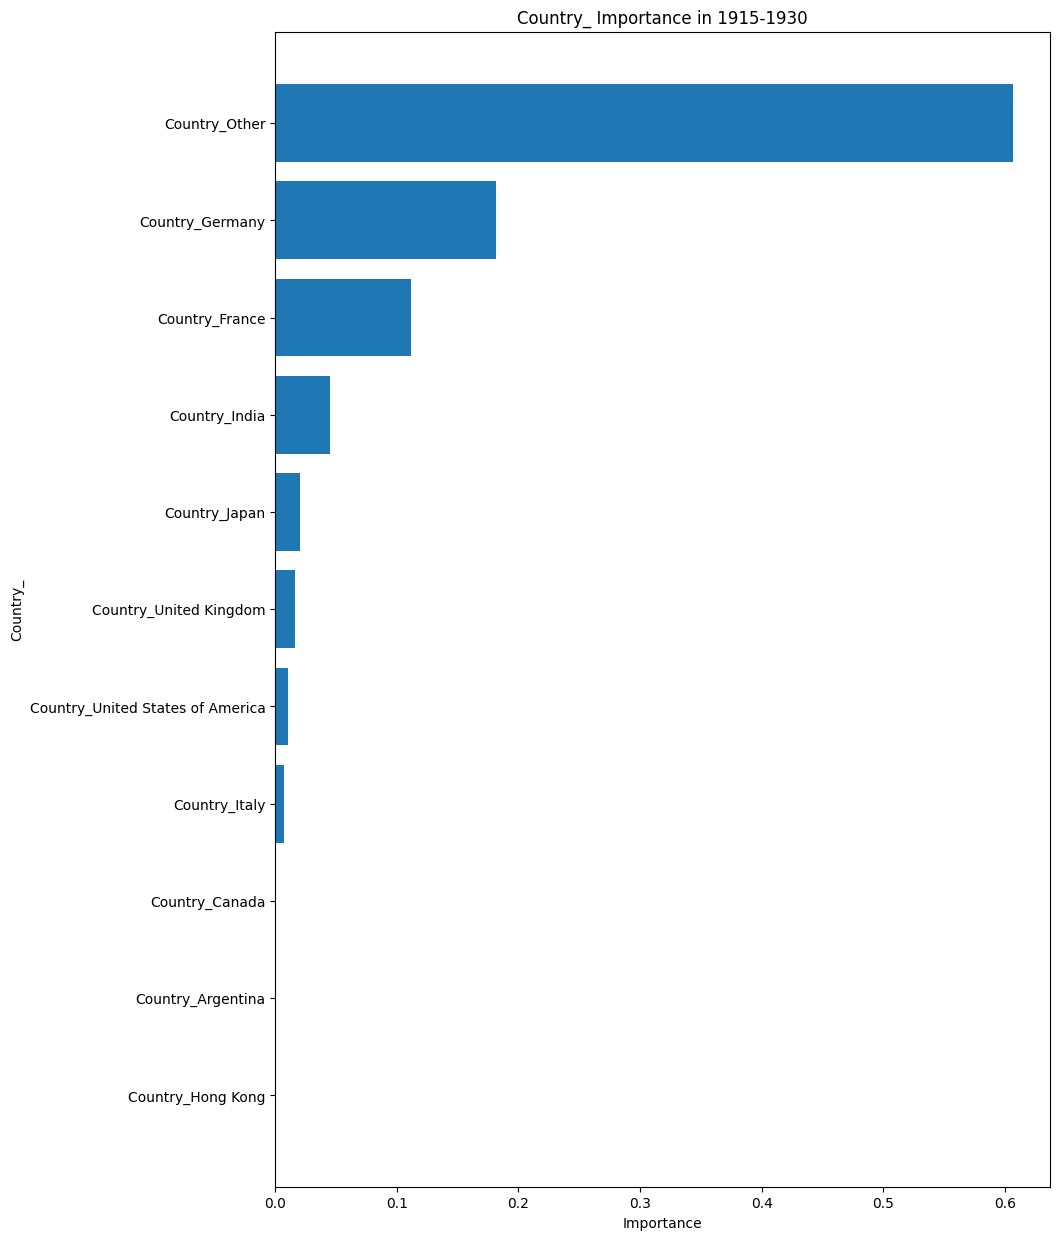

(4, 4)


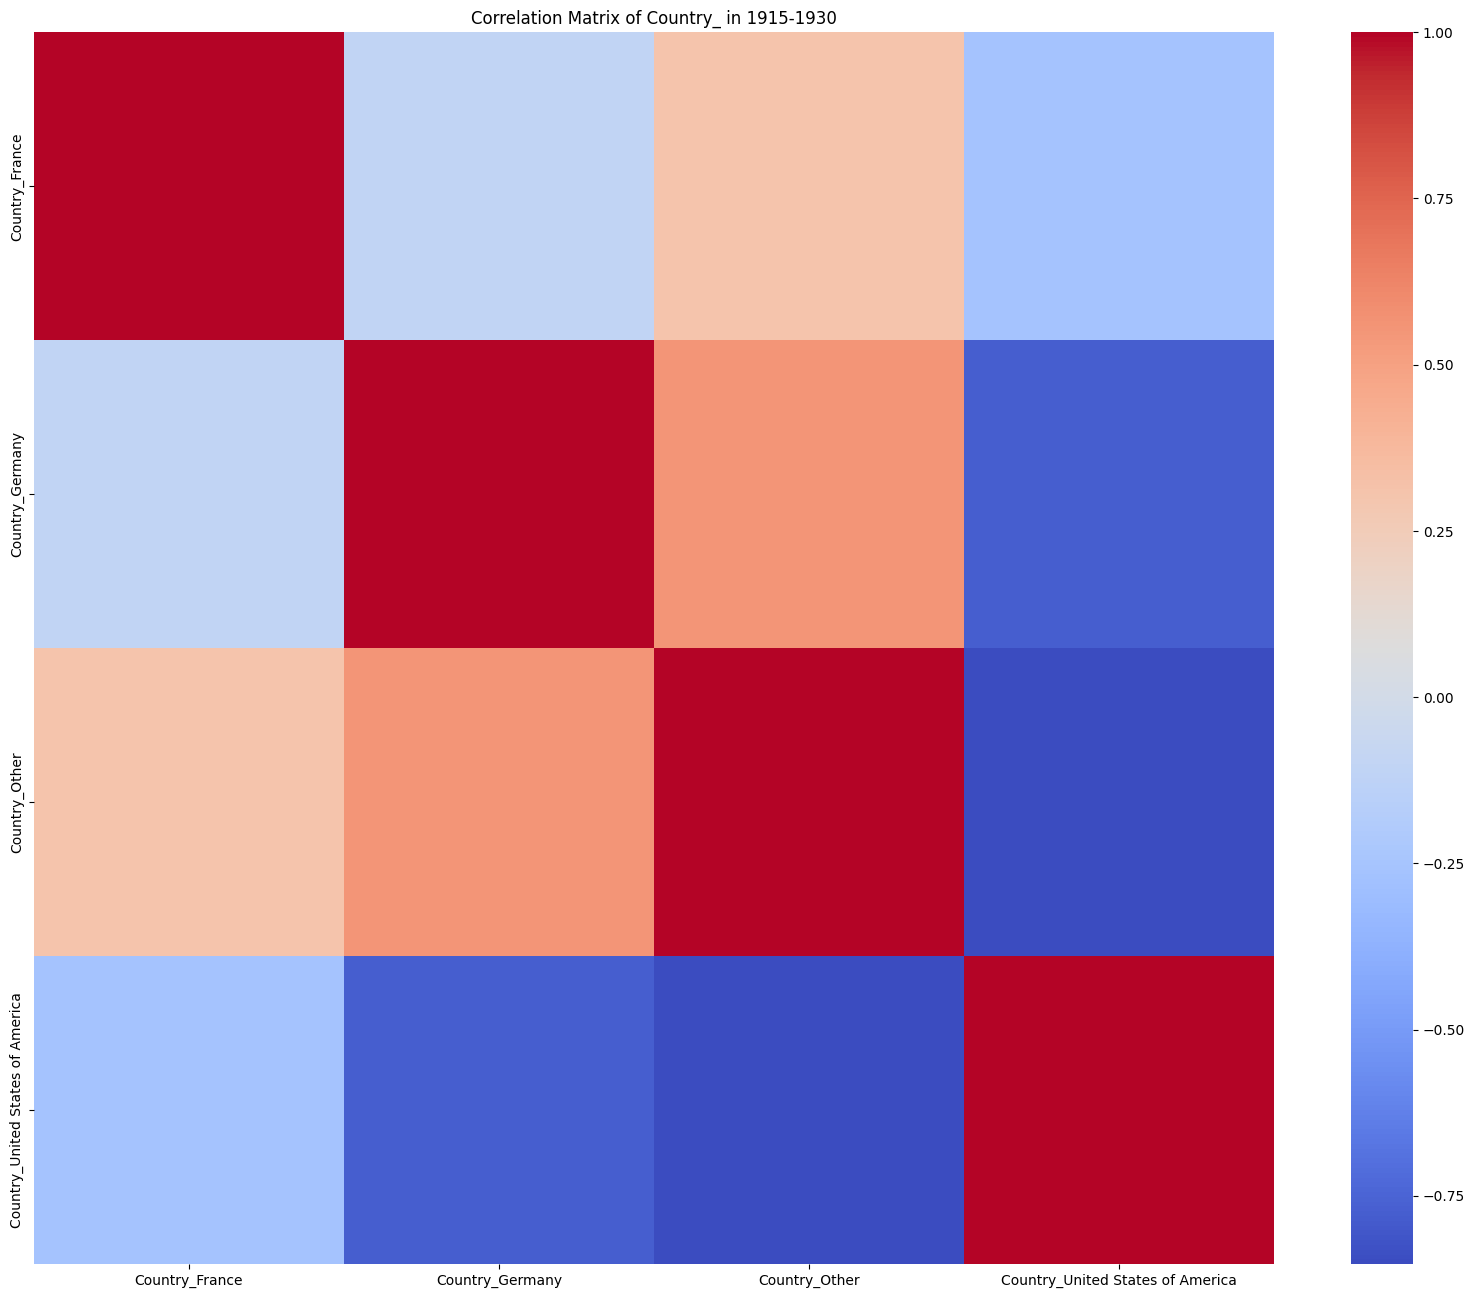

In [697]:
# USA dominates the production of movies at that period (emergence of Hollywood), however in the late 20's, 
# the apparition of talkies also allowed the beginning of cinematic movement in the world, like the German 
# Expressionism

print("Top 10 most frequent Countries in the 30 highest-rated movies :")
display(top_10_(df_period0,'Country_'))
plot_feature_importance(period0,df_period0,'Country_')
corr_matrix_top_(period0,df_period0,"Country_")

Top 10 most frequent Languages in the 30 highest-rated movies :



lang_silent film          24
lang_english              20
lang_german                7
lang_other                 3
lang_french                2
lang_hindi                 0
lang_italian               0
lang_japanese              0
lang_spanish               0
lang_standard mandarin     0
dtype: int64

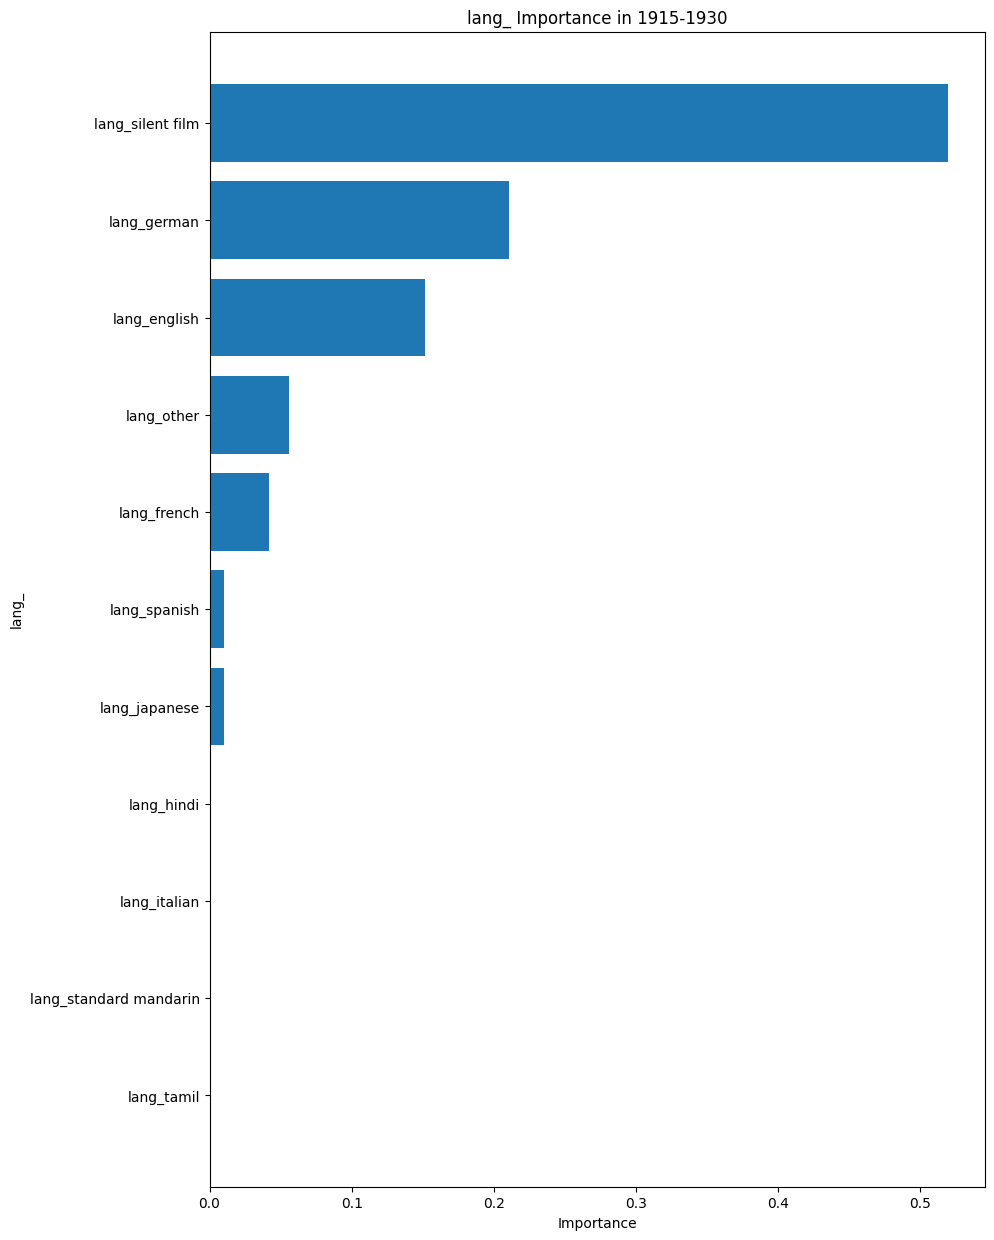

(5, 5)


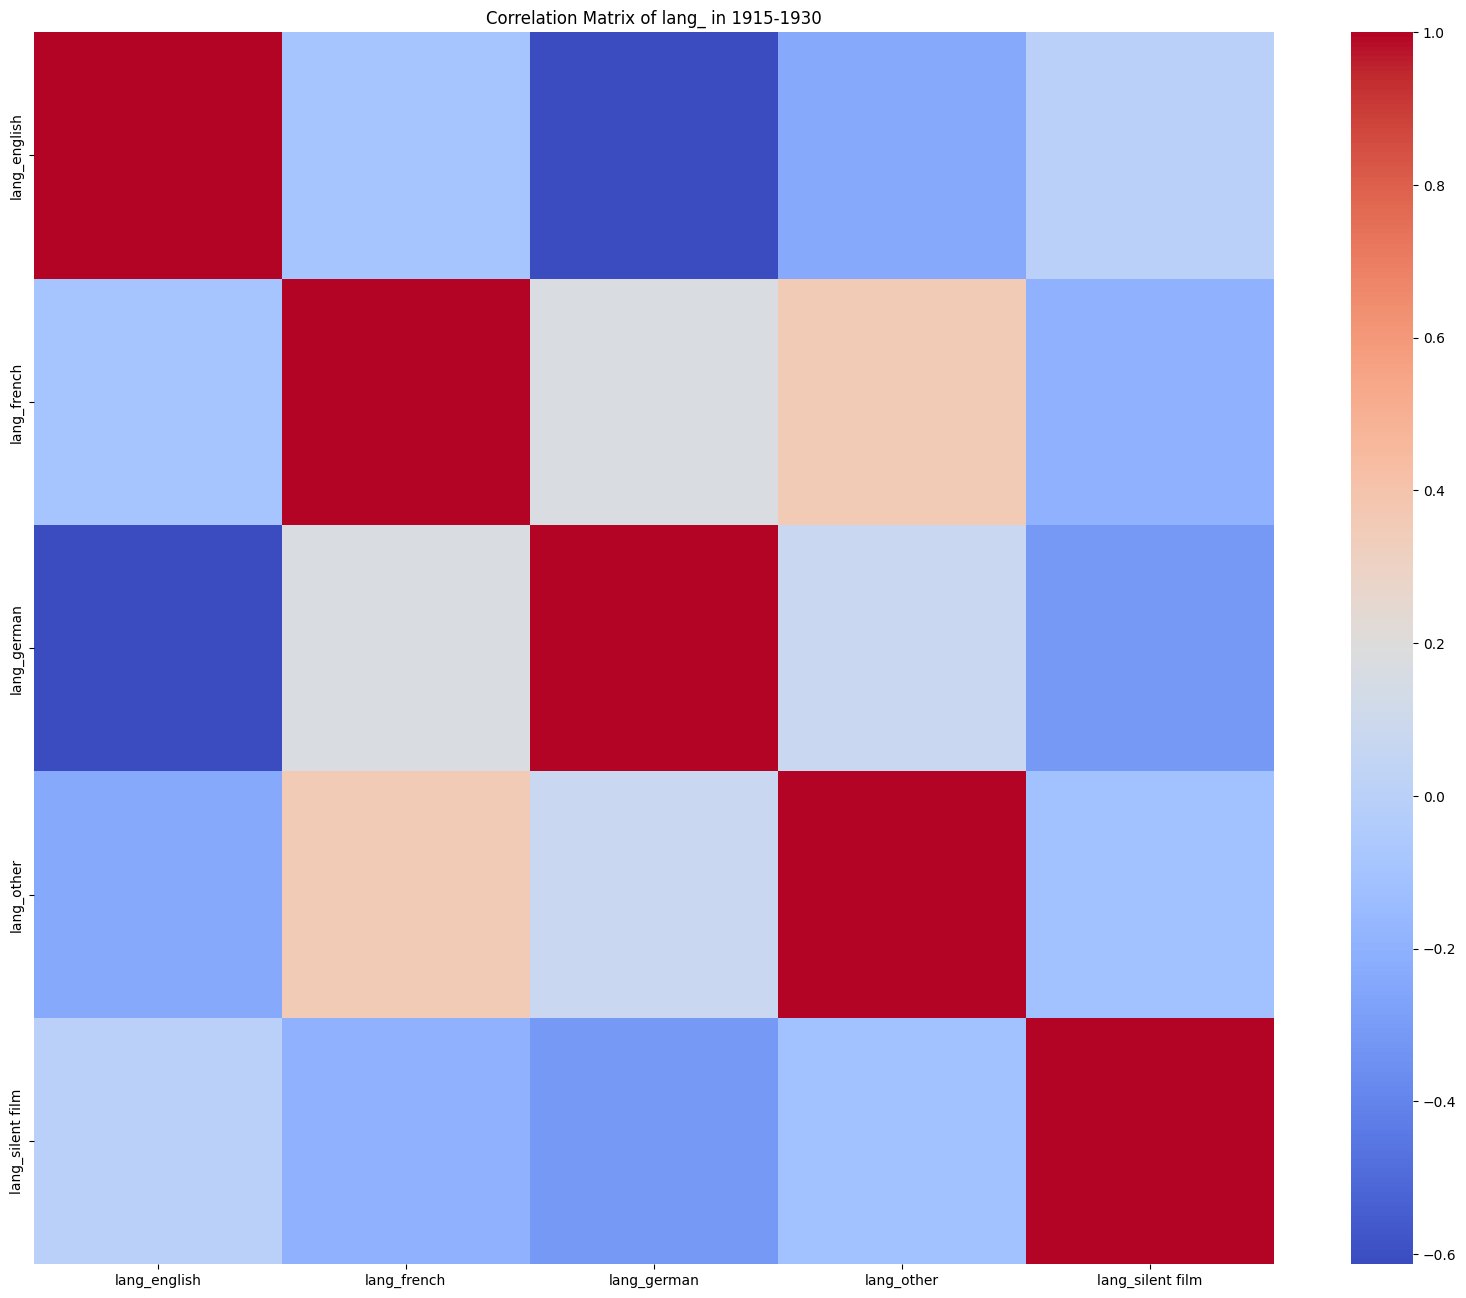

count    541.000000
mean       1.556377
std        0.546928
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: nb_of_Languages, dtype: float64

On average, each movie is available in only one language, and very few films are translated.


In [698]:
# Language Feature is not interesting to study for that period, because it is largely dominated by silent 
# films. Concerning the late 20's, when the "talkies" emerges, the language feature is really similar 
# to Country because each country produces its own film and not much translations are done.

print("Top 10 most frequent Languages in the 30 highest-rated movies :\n")
display(top_10_(df_period0,'lang_'))
plot_feature_importance(period0,df_period0,'lang_')
corr_matrix_top_(period0,df_period0,"lang_")
display(df_period0["nb_of_Languages"].describe())
print("On average, each movie is available in only one language, and very few films are translated.")

Age_Interval
Experimented Actor(30-60)    1171
Young Actor(19-30)            746
Old Actor(60+)                 99
Teenager(13-19)                93
Kid(3-13)                      32
Baby(0-3)                       4
Name: count, dtype: int64

35.988013698630134

Age_Interval
Experimented Actor(30-60)    1171
Young Actor(19-30)            746
Old Actor(60+)                 99
Teenager(13-19)                93
Kid(3-13)                      32
Baby(0-3)                       4
Name: count, dtype: int64

Actor_gender
M    1400
F     744
Name: count, dtype: int64

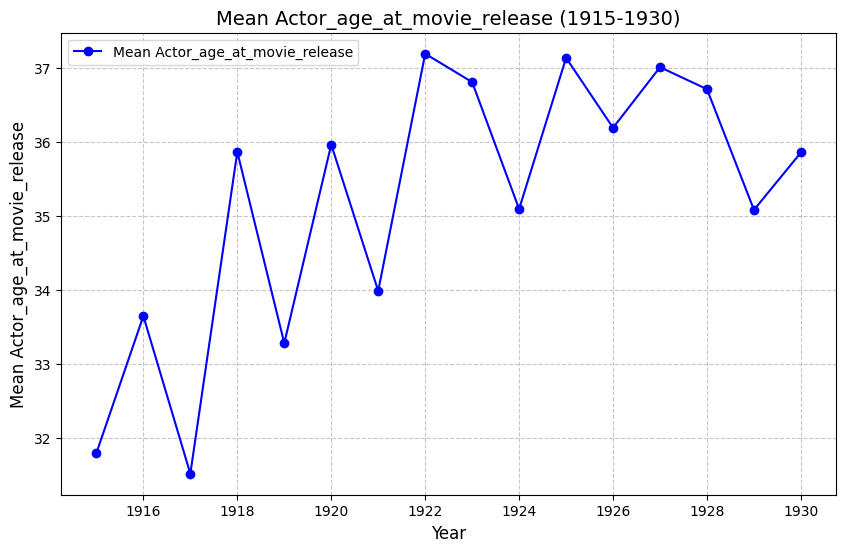

In [700]:
# When comparing the evolution of the mean_Age on the period, we notice the increase of the mean.
# The introduction of sound in films required actors with strong vocal skills and the ability to deliver 
# lines effectively. Many experienced actors from the silent era, who were already in their mid-30s, 
# transitioned into talkies, leading to an increase in the average age.
df_char0 = characters_clean[characters_clean["Year_Interval"]==period0]
display(df_char0.sort_values("averageRating")['Age_Interval'].value_counts())
display(df_char0[df_char0['Year']>1926].sort_values("averageRating").groupby("Wikipedia_movie_ID").head(30).apply(lambda x:x)['Actor_age_at_movie_release'].mean())


display(df_char0['Age_Interval'].value_counts())
display(df_char0['Actor_gender'].value_counts())

plot_mean_per_year_(period0,df_char0,'Actor_age_at_movie_release')

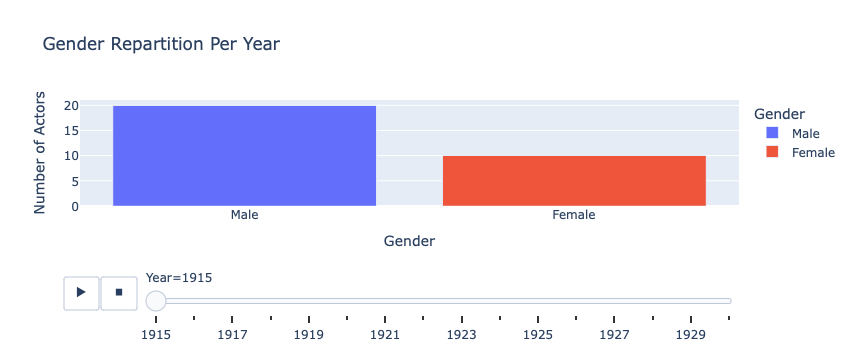

In [701]:
import plotly.express as px

count = df_char0.groupby('Year').apply(lambda x: x['Actor_gender'].value_counts(),include_groups=False).reset_index()

df_long = count.melt(id_vars='Year', 
                  value_vars=['M', 'F'], 
                  var_name='gender', 
                  value_name='count')

df_long['gender'] = df_long['gender'].replace({'M': 'Male', 'F': 'Female'})

# Create a bar chart with a slider
fig = px.bar(
    df_long,
    x='gender',
    y='count',
    color='gender',
    animation_frame='Year',  # Slider is automatically created based on the 'year'
    title='Gender Repartition Per Year',
    labels={'count': 'Number of Actors', 'gender': 'Gender'},
)

# Update layout for better visuals
fig.update_layout(
    xaxis_title="Gender",
    yaxis_title="Number of Actors",
    legend_title="Gender",
    transition={'duration': 500},  # Smooth transitions
)

# Show the plot
fig.show()

Globally, there are twice as much Male actors than Female actors

# 1930-1950 (Studio Glory)

In [702]:
period1 = periods[1]
df_period1 = movies_clean[movies_clean["Year_Interval"] == period1]
df_period1.shape

(3259, 73)

Top 10 most frequent genres in the 30 highest-rated movies :


Genre_Drama              28
Genre_Black-and-white    23
Genre_Other              20
Genre_Romance Film        7
Genre_World cinema        6
Genre_Crime Fiction       6
Genre_Comedy              5
Genre_War film            5
Genre_Thriller            5
Genre_Romantic drama      5
dtype: int64

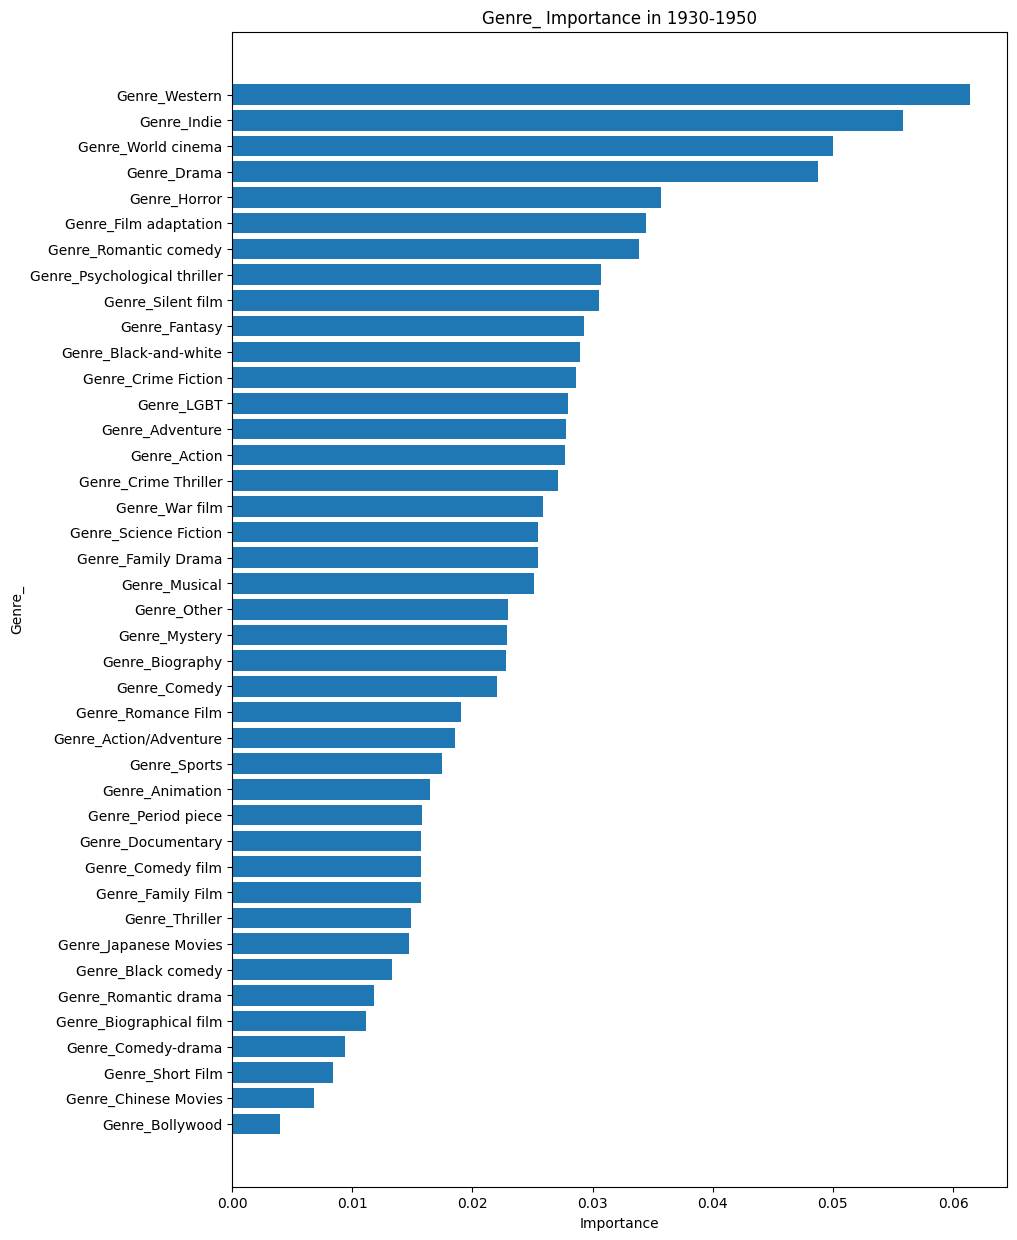

(28, 28)


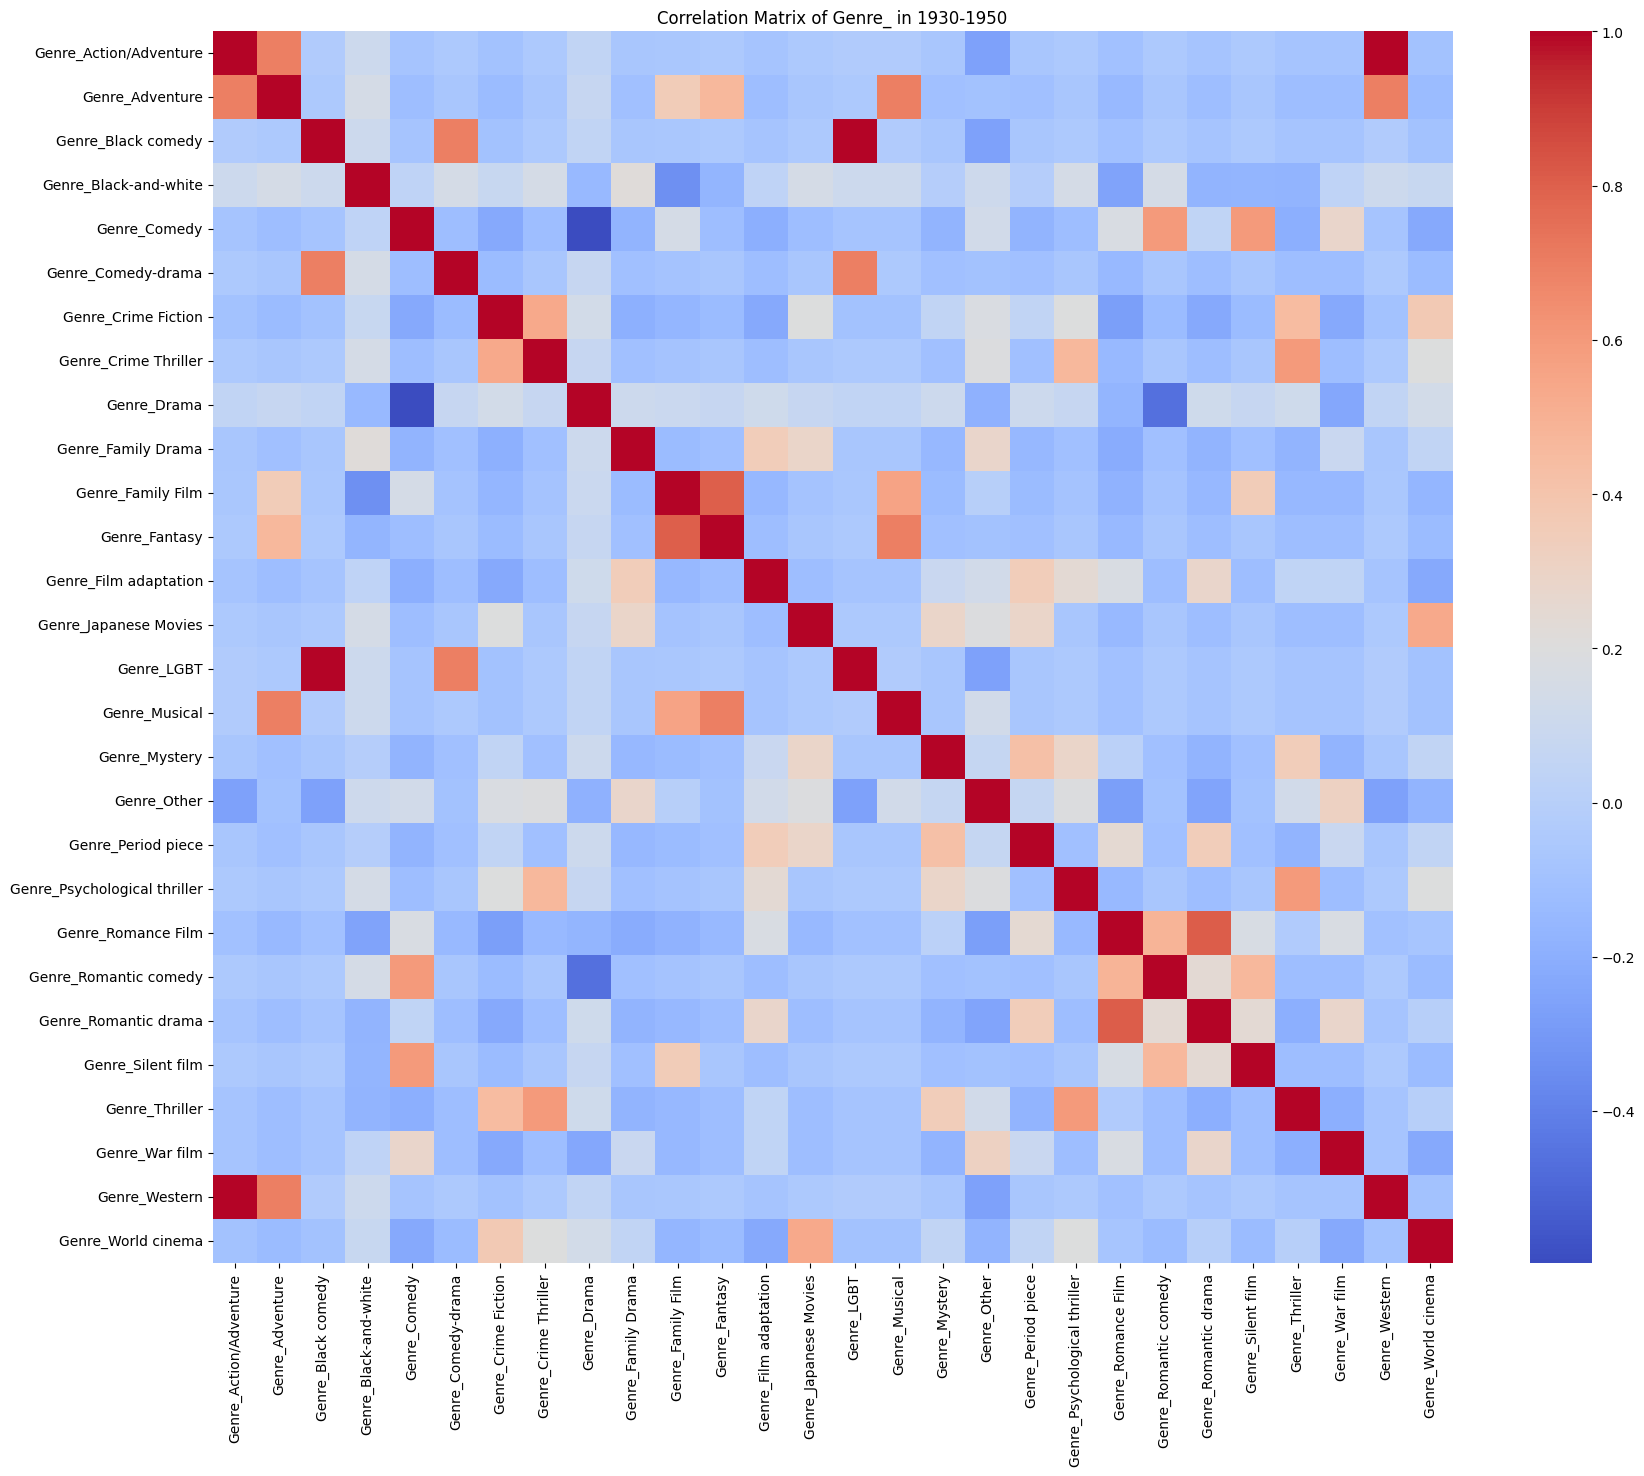

count    3259.000000
mean        3.780608
std         1.970947
min         1.000000
25%         2.000000
50%         4.000000
75%         5.000000
max        11.000000
Name: nb_of_Genres, dtype: float64

count    541.000000
mean       4.364140
std        2.130582
min        1.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       14.000000
Name: nb_of_Genres, dtype: float64

In [712]:
# We notice a light decrease of the number of genres per film, as well as the 

print("Top 10 most frequent genres in the 30 highest-rated movies :")
display(top_10_(df_period1,'Genre_'))
plot_feature_importance(period1,df_period1,'Genre_')
corr_matrix_top_(period1,df_period1,'Genre_')
display(df_period1['nb_of_Genres'].describe())
display(df_period0['nb_of_Genres'].describe())

Top 10 most productive contries in the 30 highest-rated movies :


Country_United States of America    22
Country_Other                        3
Country_France                       2
Country_Japan                        2
Country_Germany                      1
Country_Italy                        1
Country_United Kingdom               1
Country_Argentina                    0
Country_Canada                       0
Country_Hong Kong                    0
dtype: int64

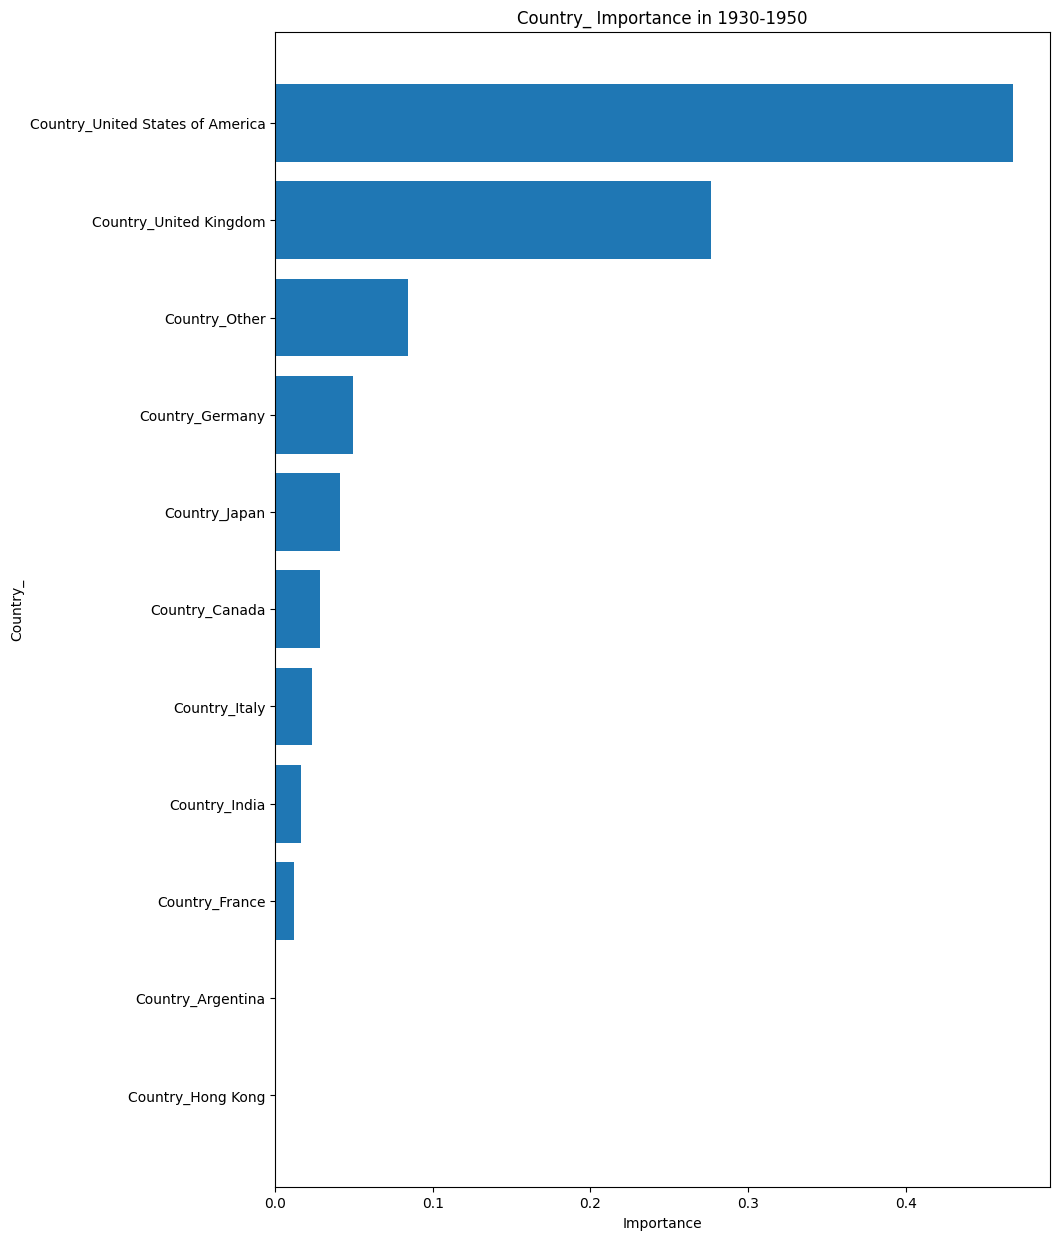

(7, 7)


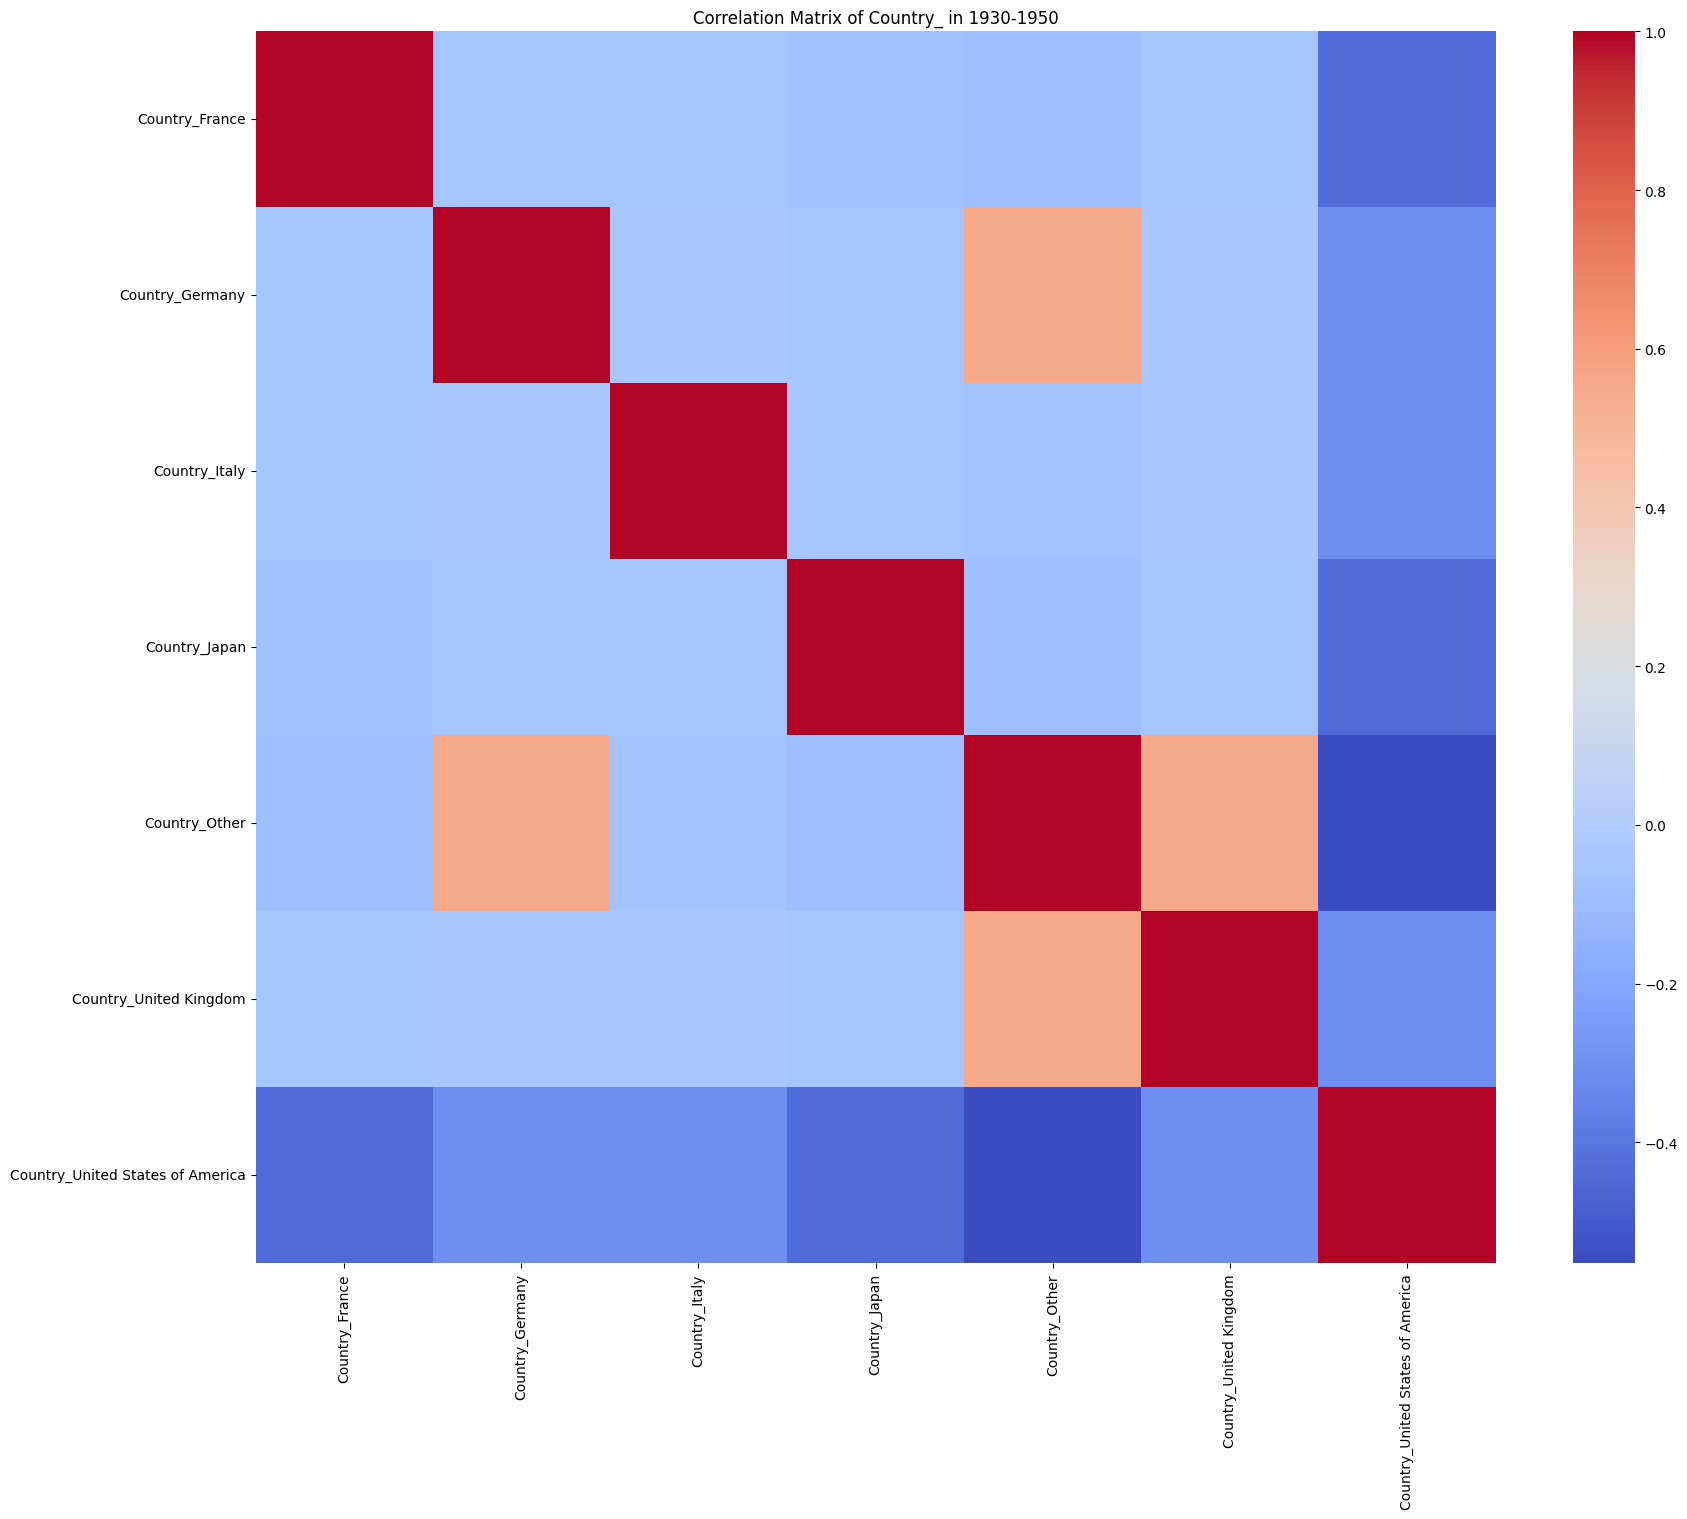

In [716]:
# OverDominance of Hollywood oon the other countries : it's Hollywood Golden Age !

print("Top 10 most productive contries in the 30 highest-rated movies :")
display(top_10_(df_period1,'Country'))
plot_feature_importance(period1,df_period1,'Country_')
corr_matrix_top_(period1,df_period1,"Country_")

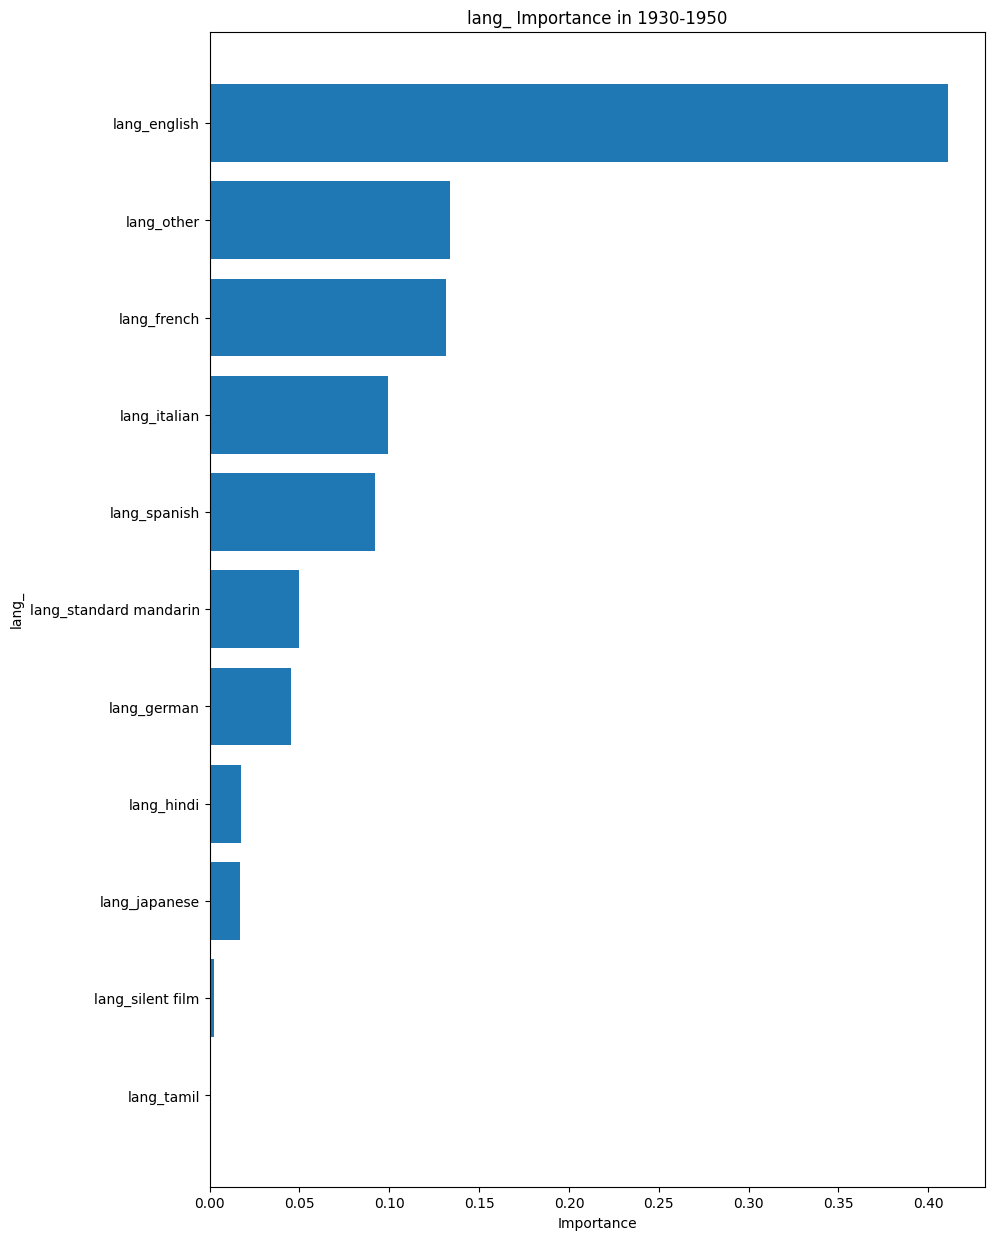

(7, 7)


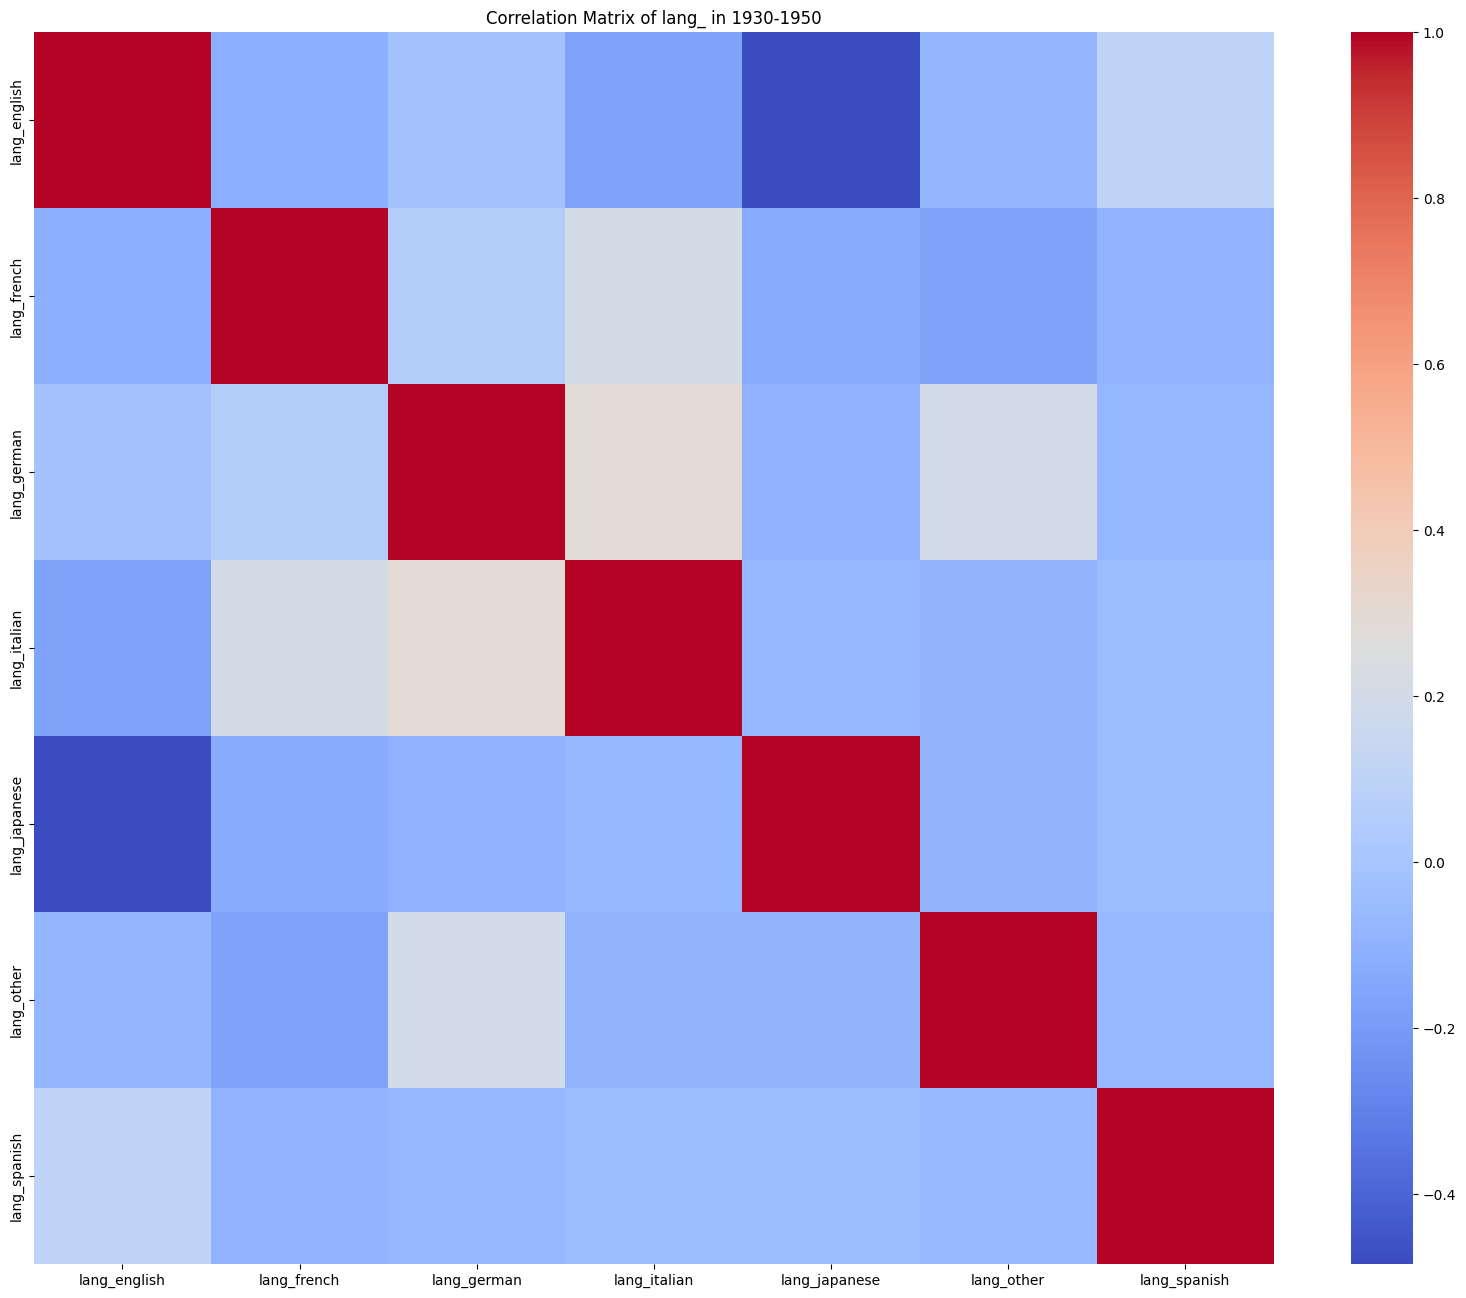

In [719]:
# Whereas English is still the most important language in the cinema world, we noticed the emergence of 
# other languages as french, italian or spanish. We also noticed the quick disparition of the silent films.

plot_feature_importance(period1,df_period1,'lang_')
corr_matrix_top_(period1,df_period1,"lang_")

# 1950-1970 (Auteur Rise)

In [567]:
df_period2 = movies_clean[movies_clean["Year_Interval"] == periods[2]]
df_period2.shape

(3983, 73)

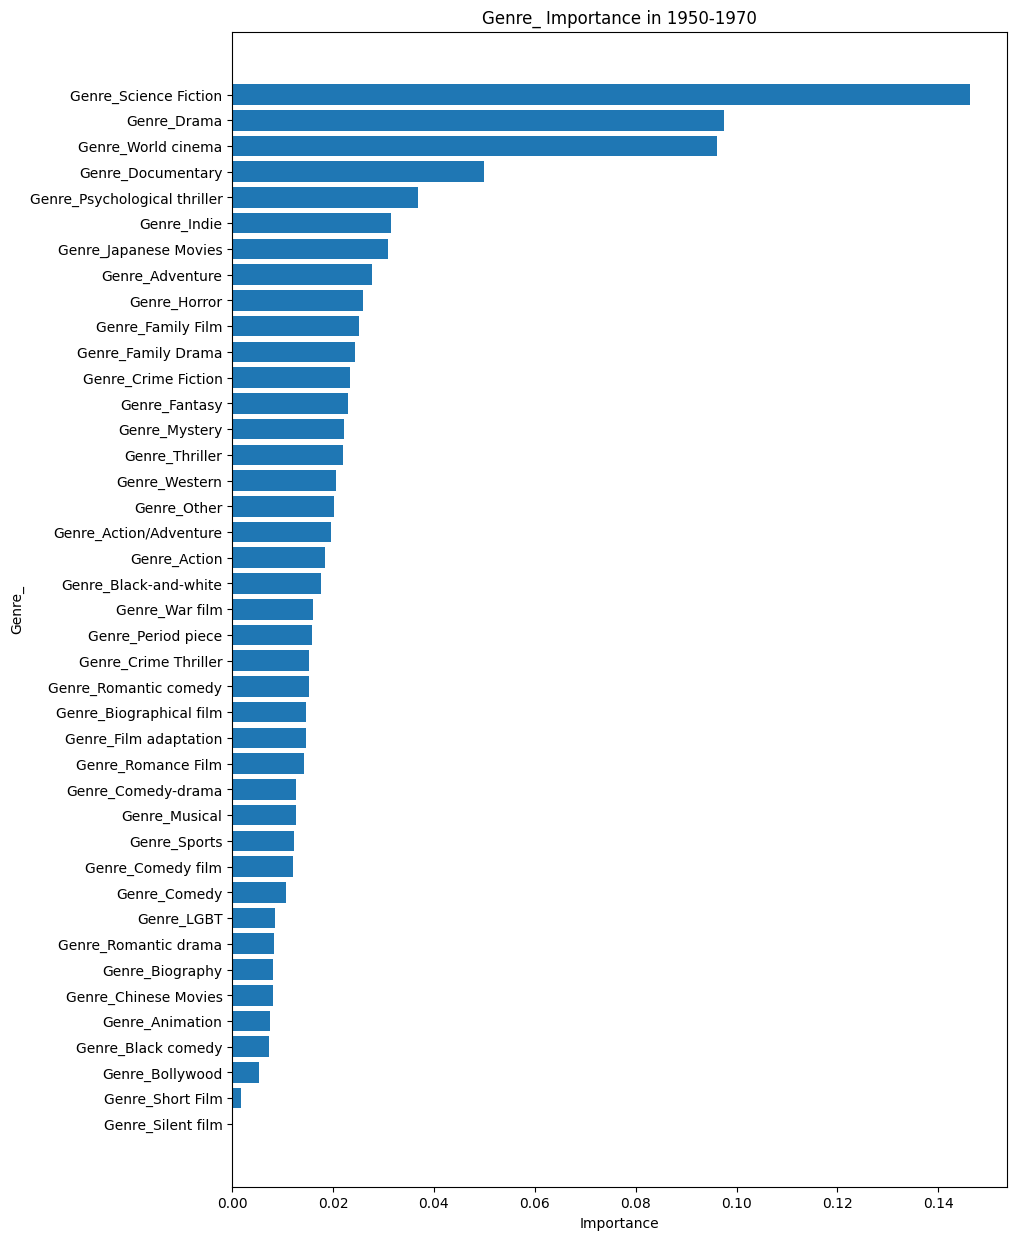

(25, 25)


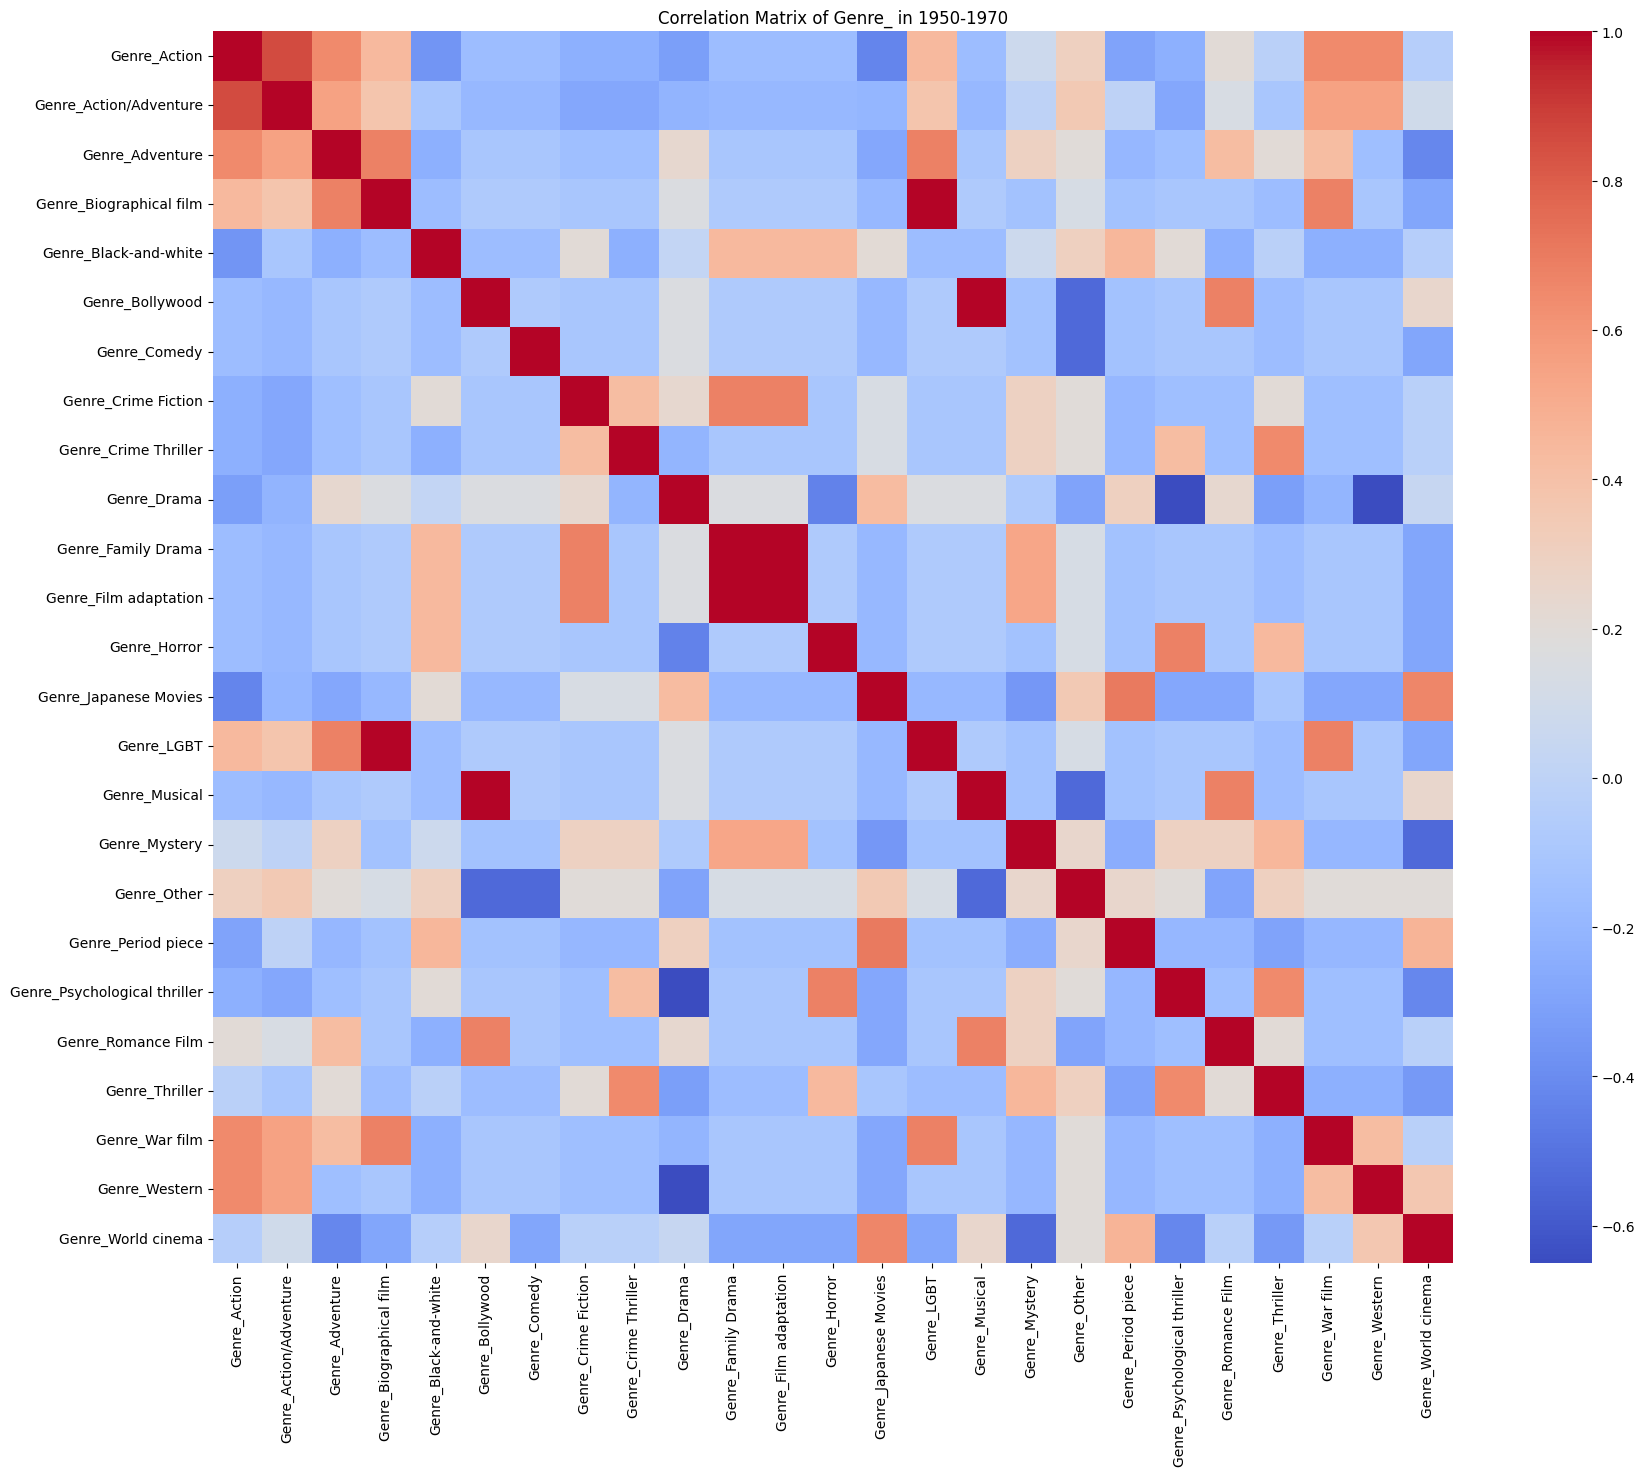

In [517]:
plot_feature_importance('1950-1970',df_period2,'Genre_')
corr_matrix_top_(periods[2],df_period2,"Genre_")

(6, 6)


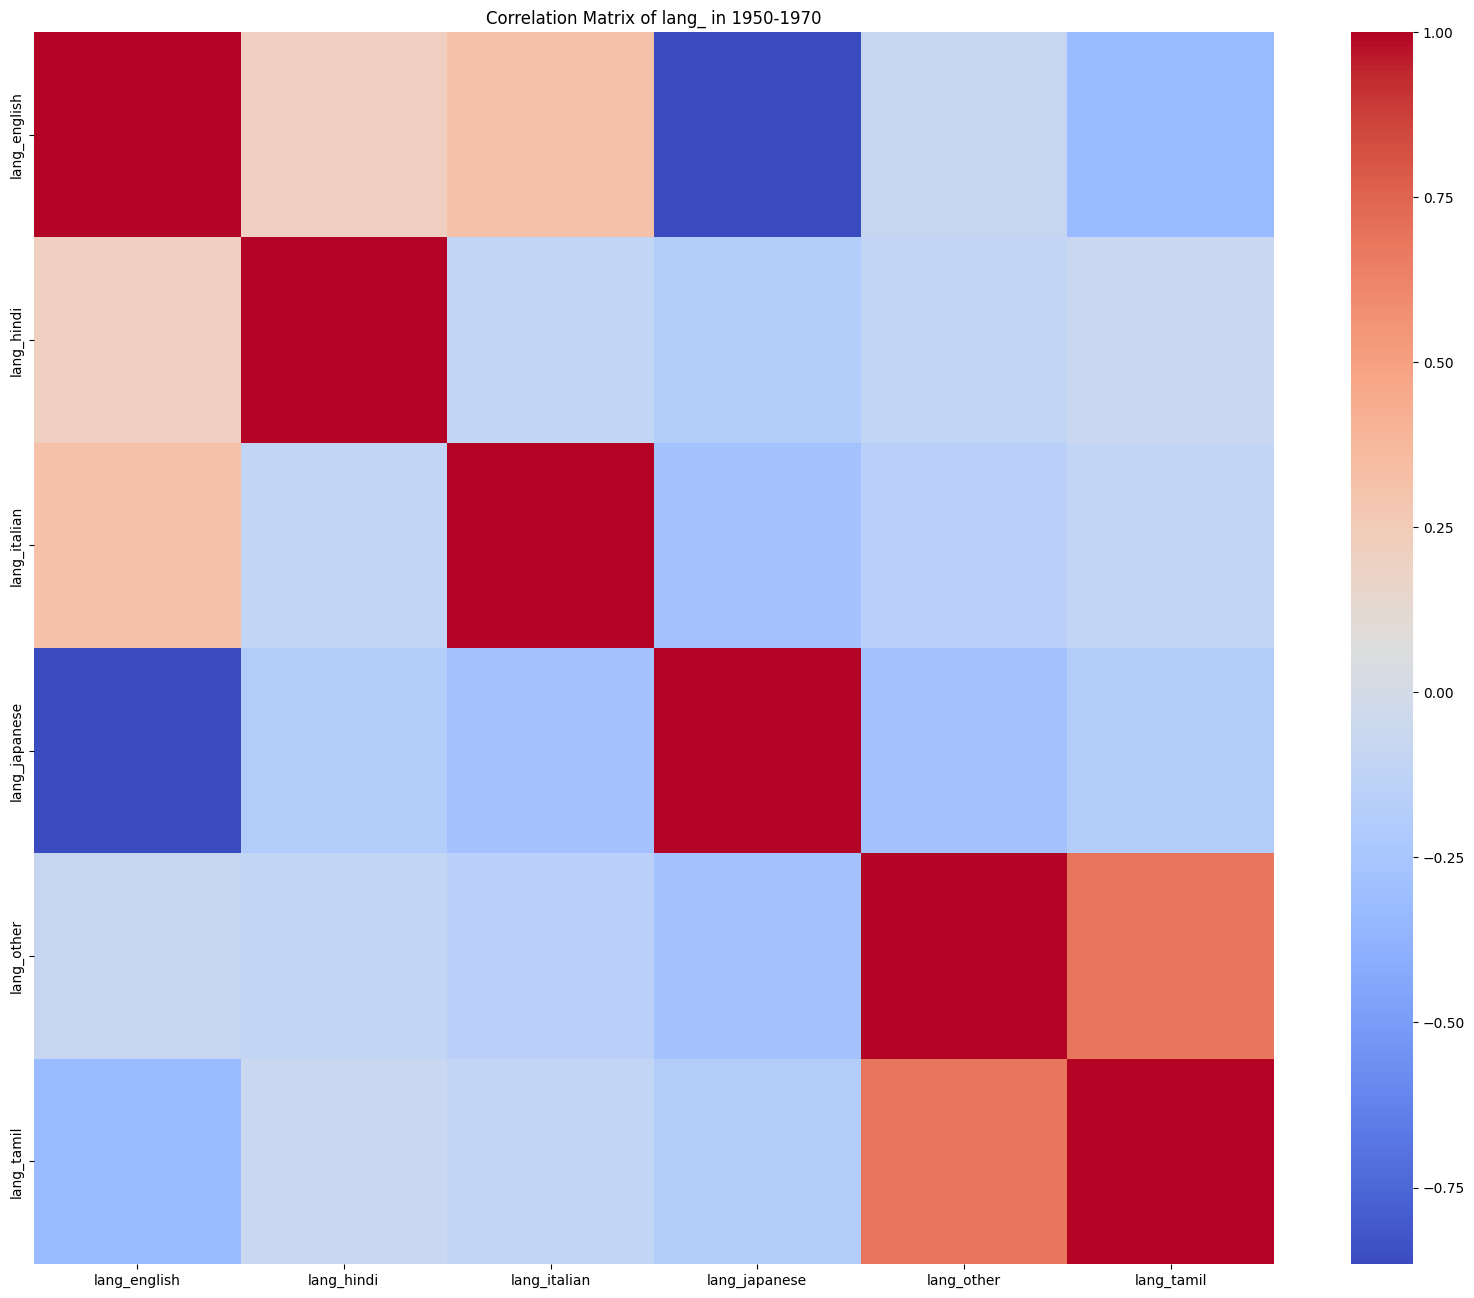

In [518]:
corr_matrix_top_(periods[2],df_period2,"lang_")

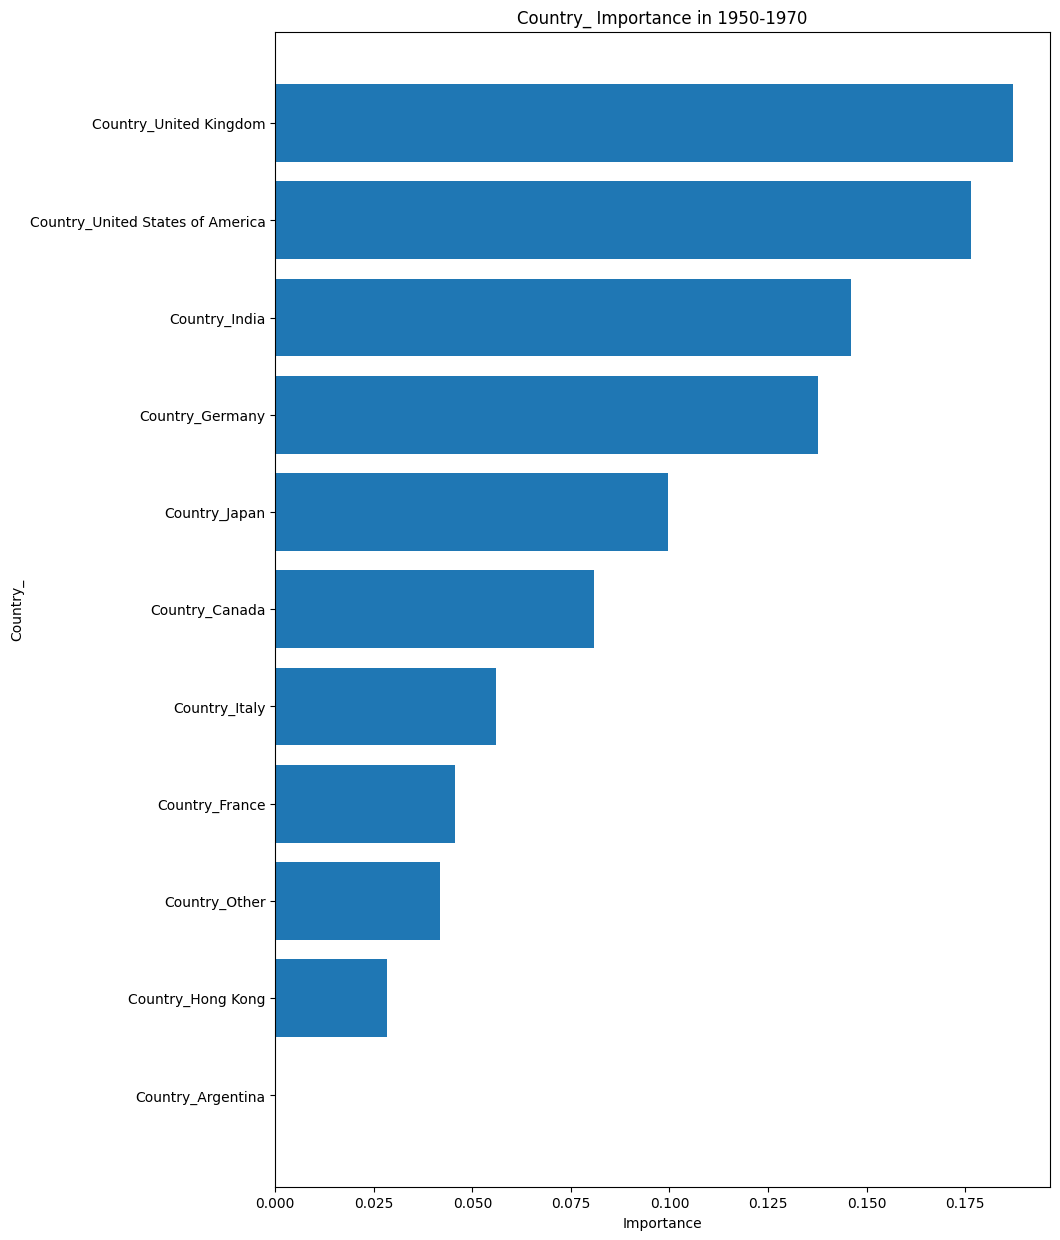

(6, 6)


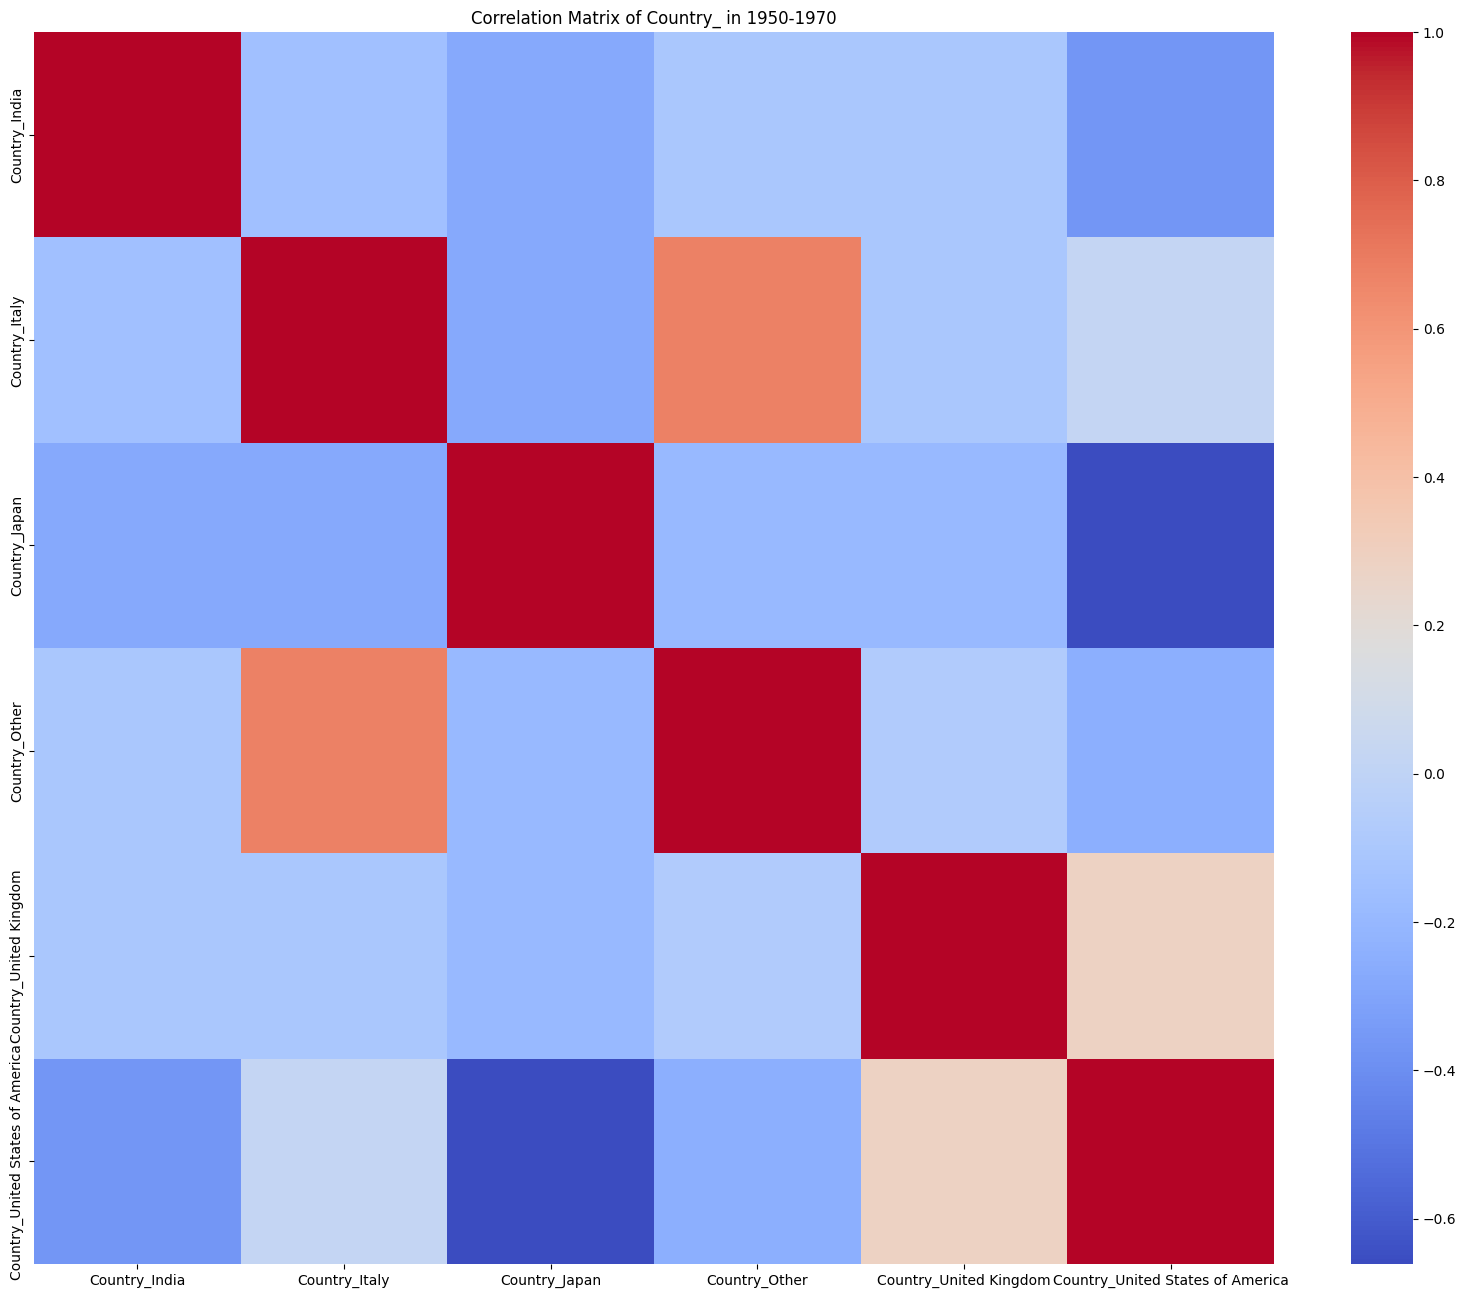

In [519]:
plot_feature_importance('1950-1970',df_period2,'Country_')
corr_matrix_top_(periods[2],df_period2,"Country_")

# 1970 - 2000 (Global Blockbusters)

In [568]:
df_period3 = movies_clean[movies_clean["Year_Interval"] == periods[3]]
df_period3.shape

(9227, 73)

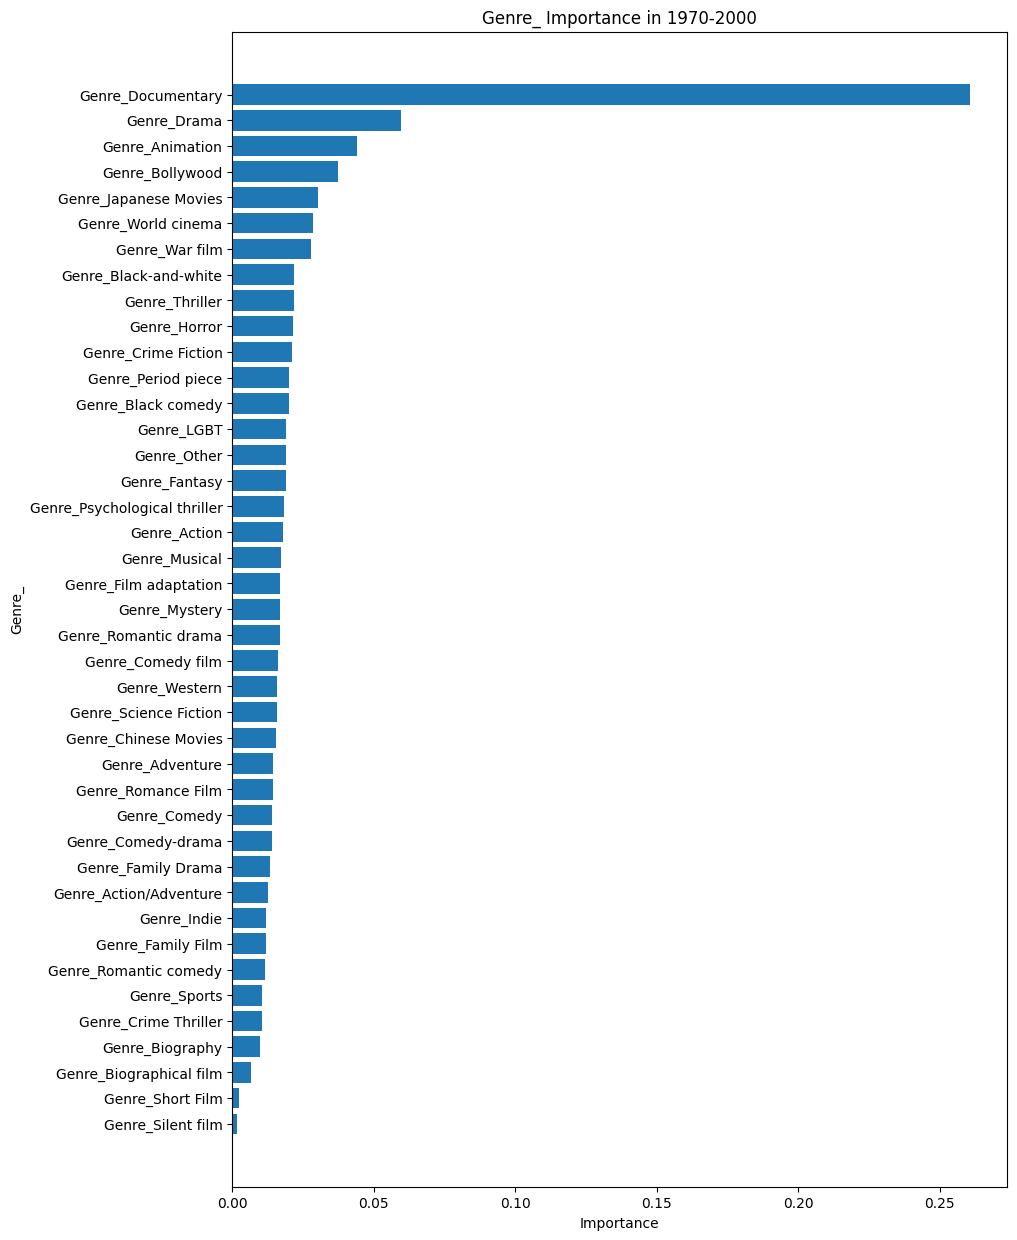

(27, 27)


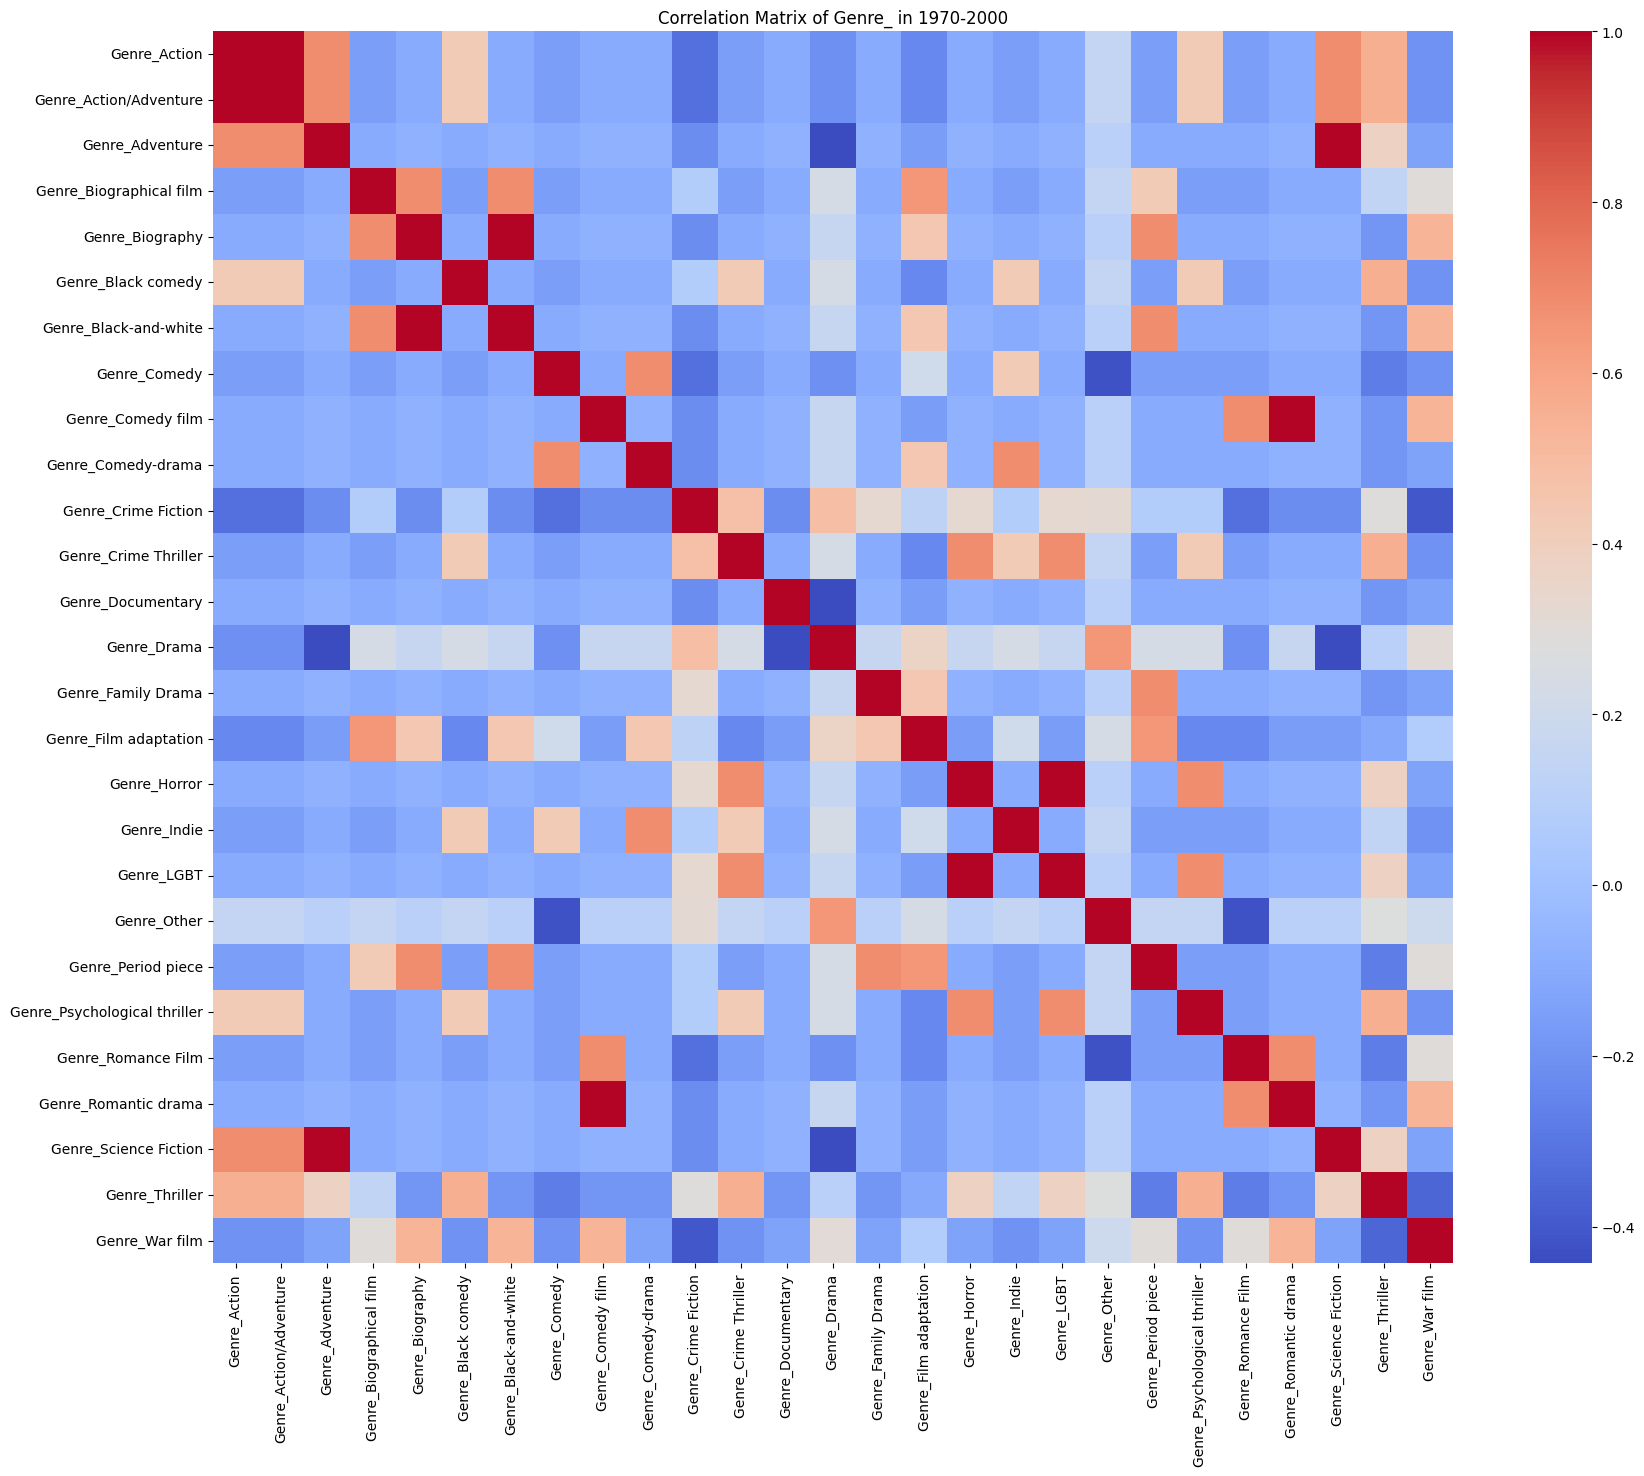

In [521]:
plot_feature_importance('1970-2000',df_period3,'Genre_')
corr_matrix_top_(periods[3],df_period3,"Genre_")

(7, 7)


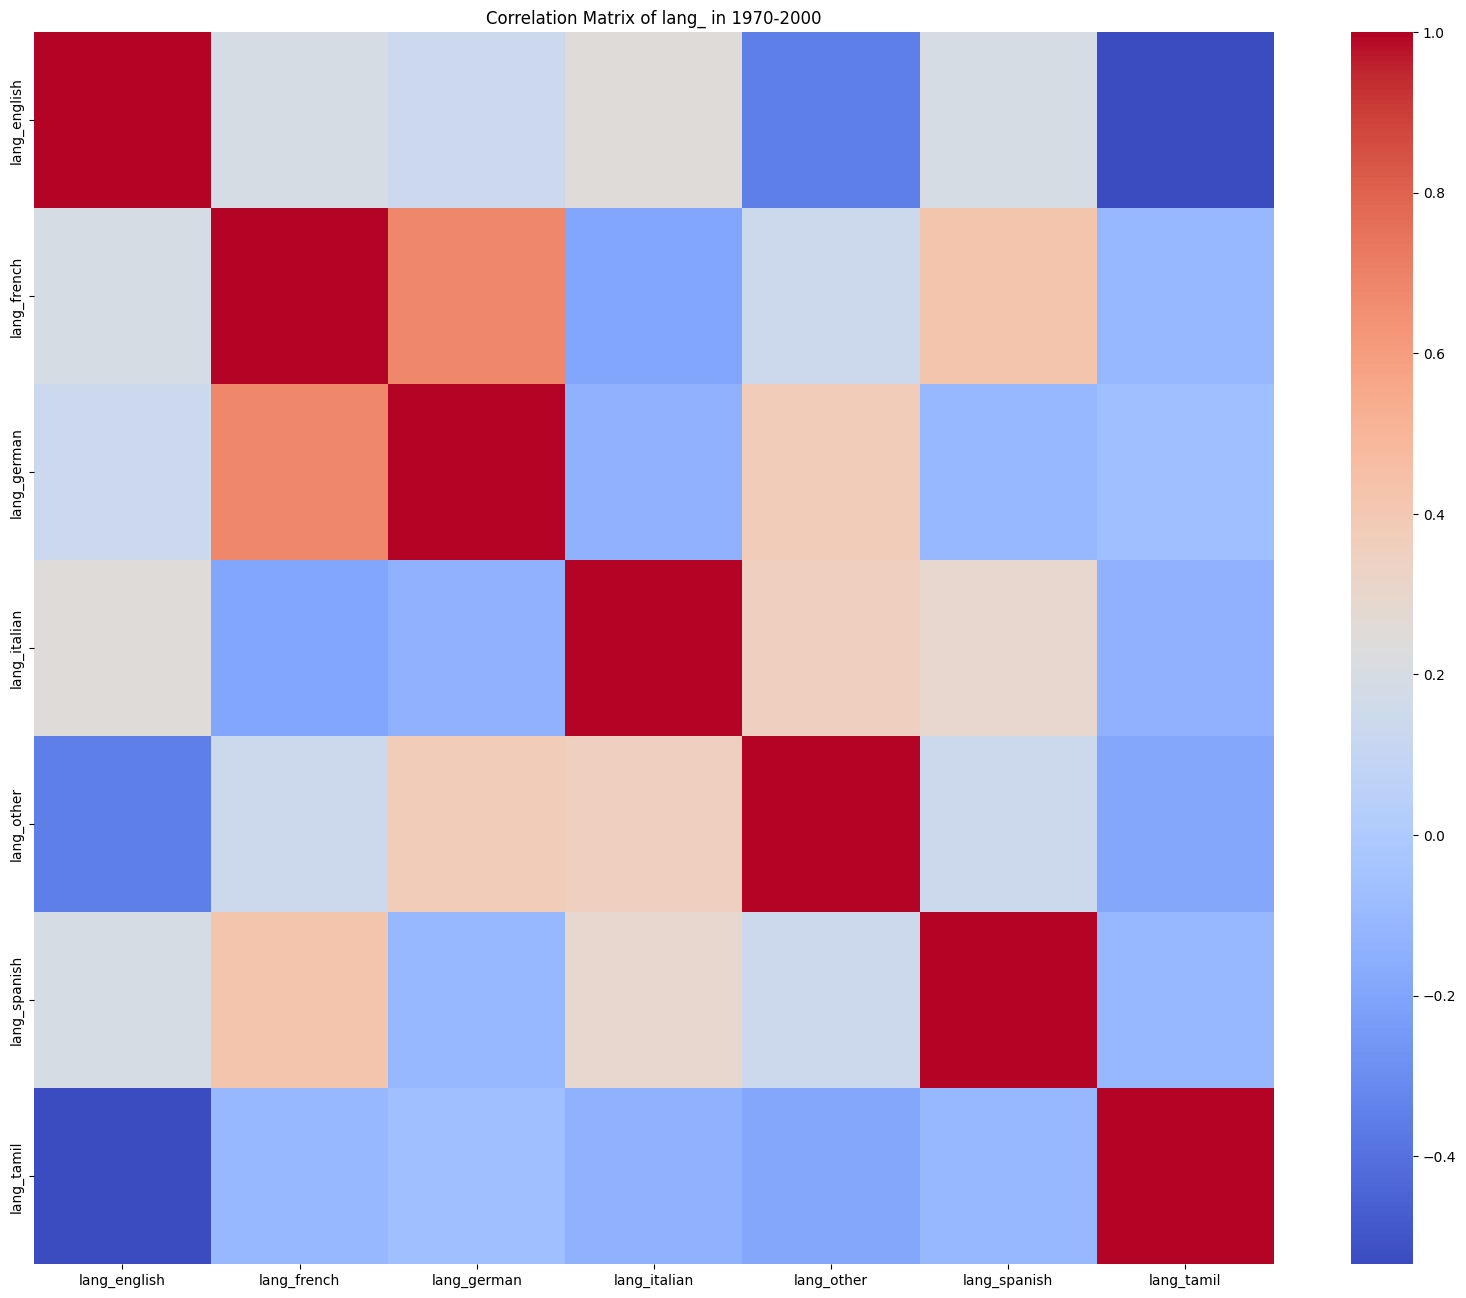

In [522]:
corr_matrix_top_(periods[3],df_period3,"lang_")

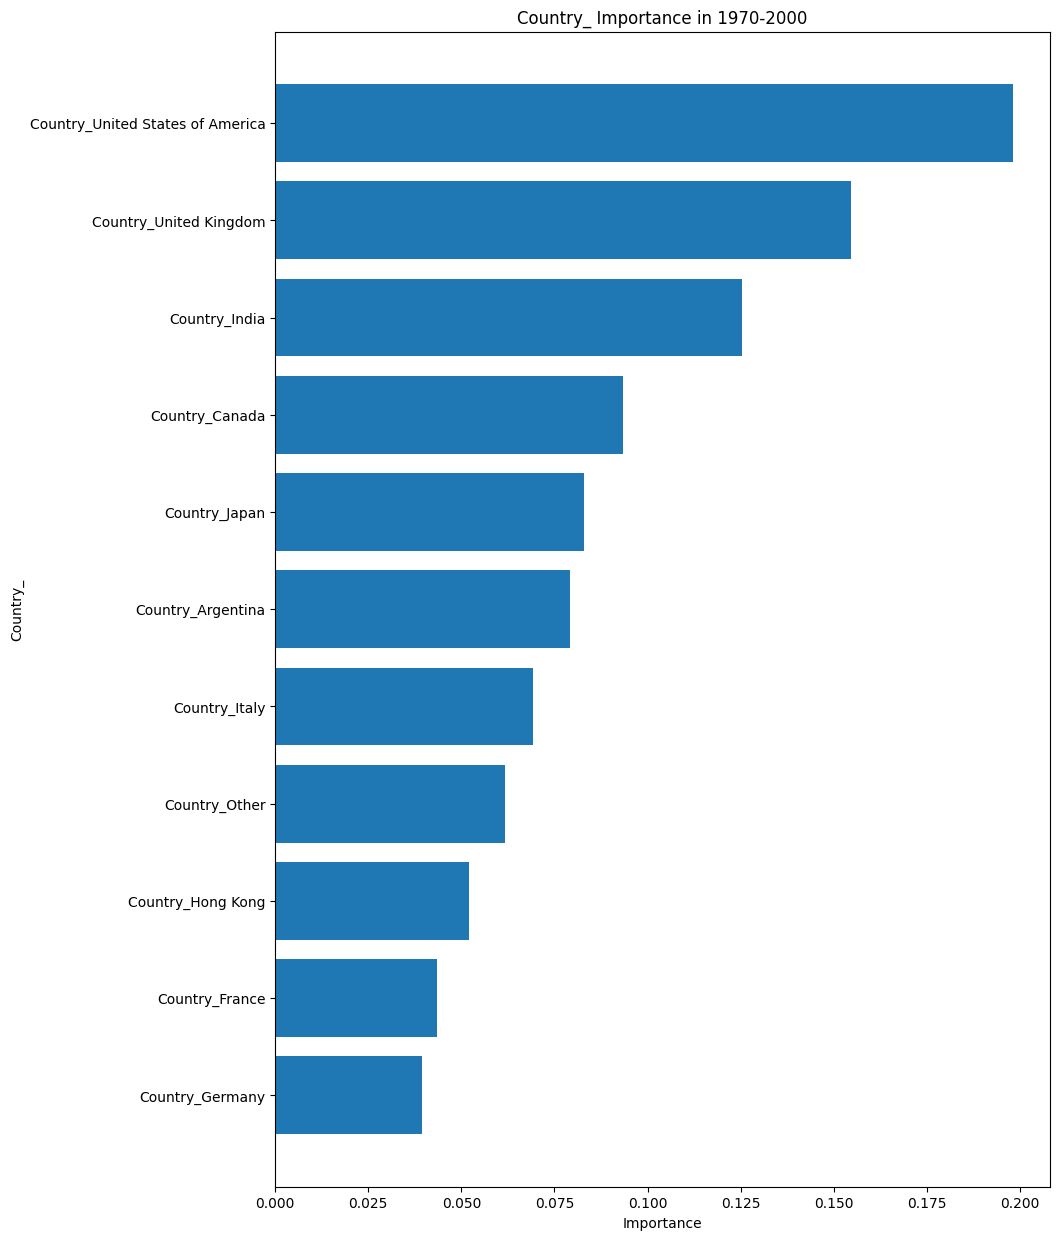

(4, 4)


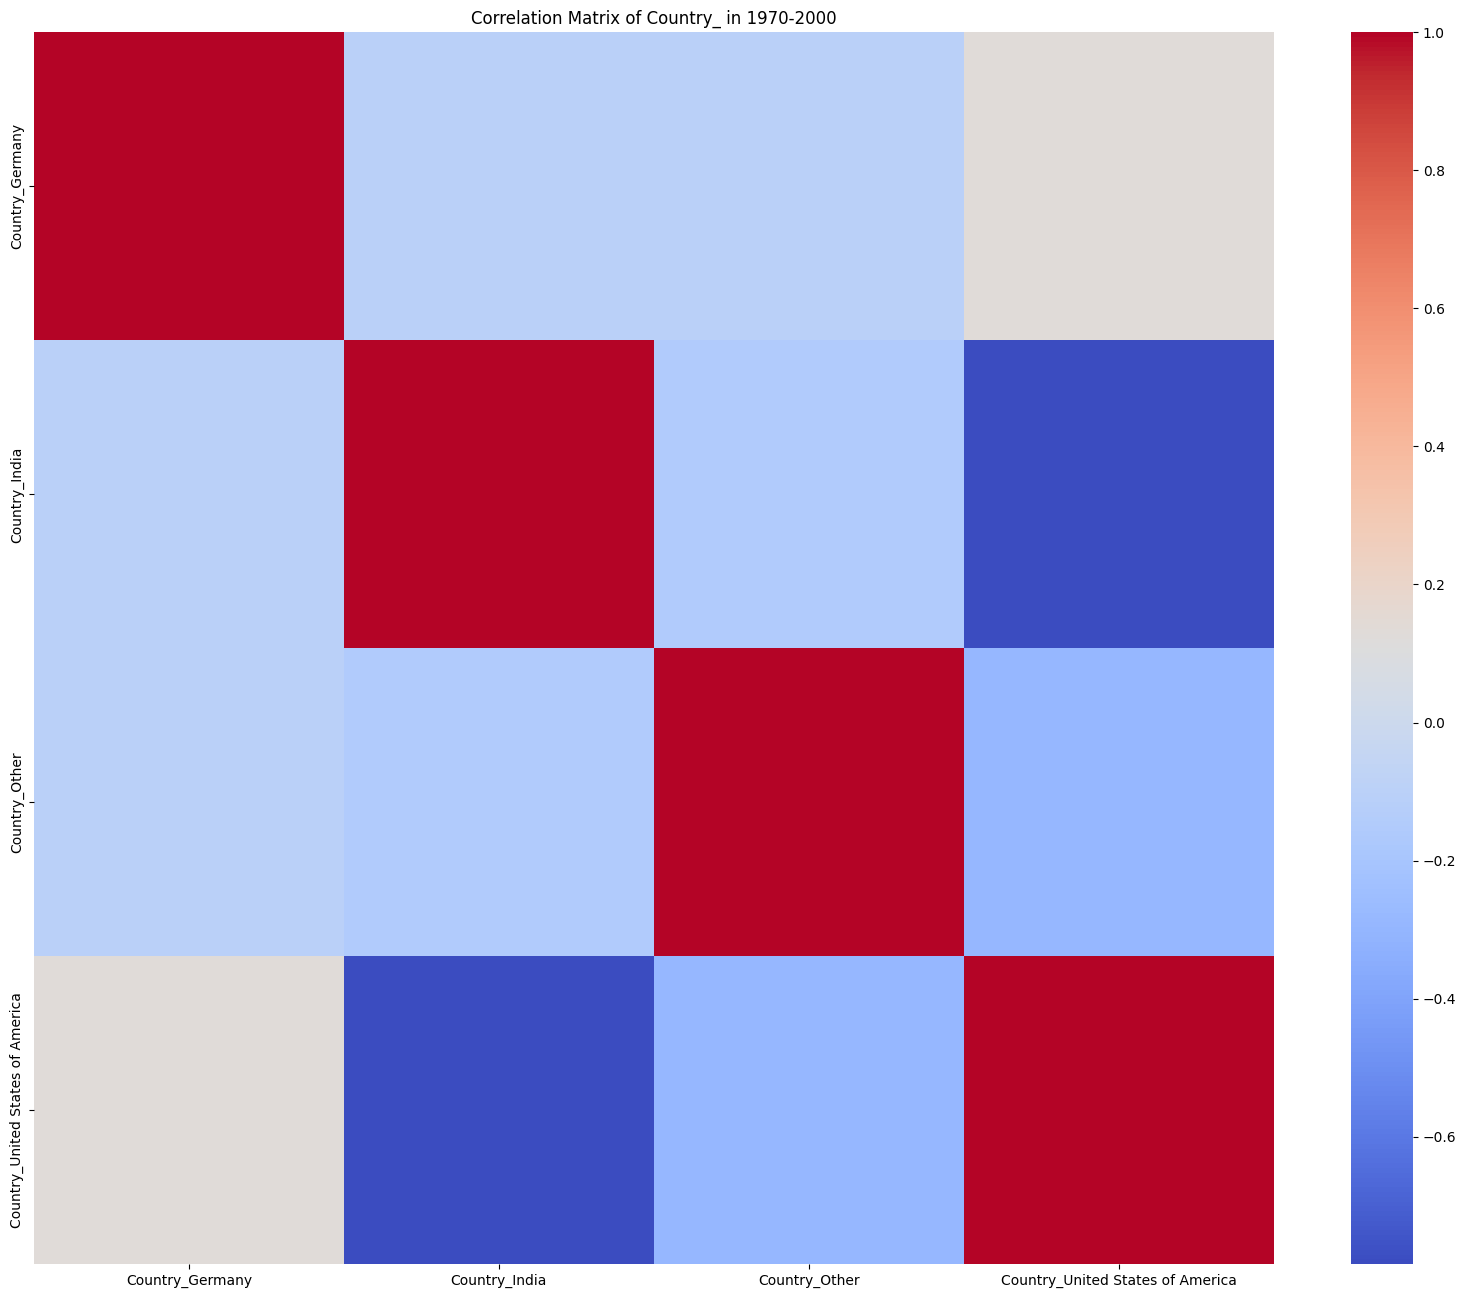

In [523]:
plot_feature_importance('1970-2000',df_period3,'Country_')
corr_matrix_top_(periods[3],df_period3,"Country_")

# 2000 - 2015 (Digital Diversity)

In [569]:
df_period4 = movies_clean[movies_clean["Year_Interval"] == periods[4]]
df_period4.shape

(8174, 73)

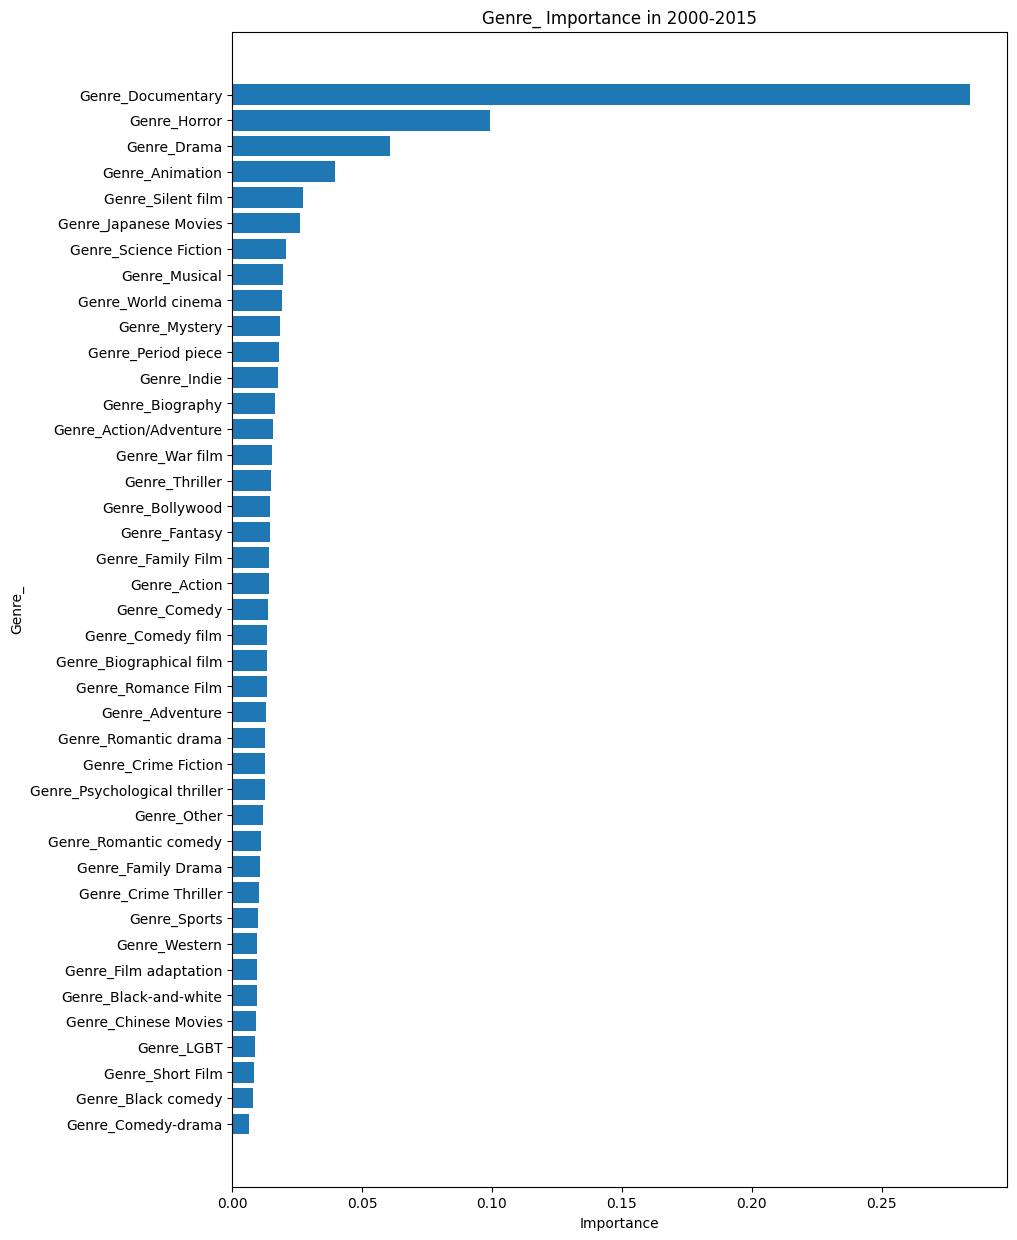

(23, 23)


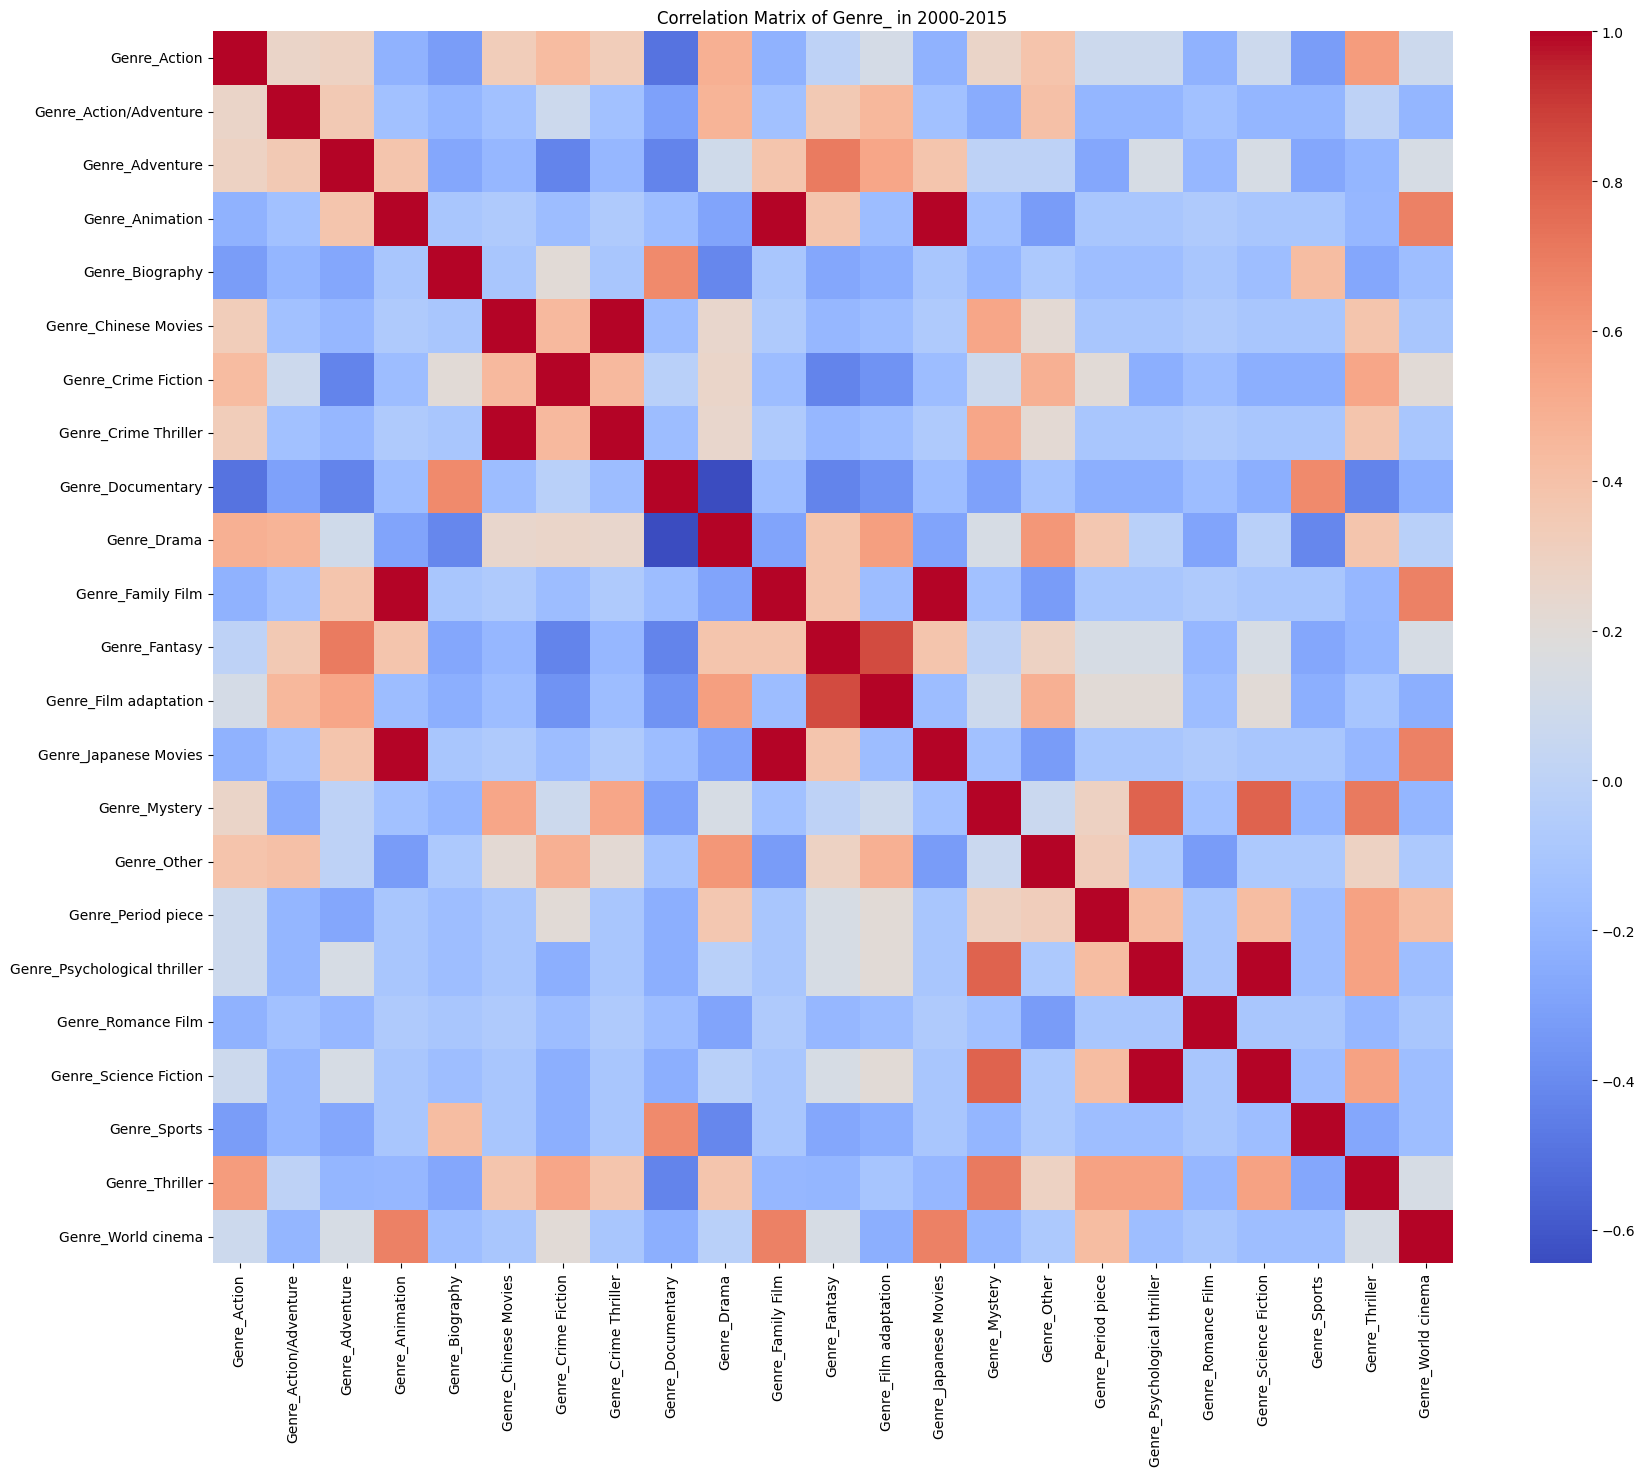

In [525]:
plot_feature_importance('2000-2015',df_period4,'Genre_')
corr_matrix_top_(periods[4],df_period4,"Genre_")

(7, 7)


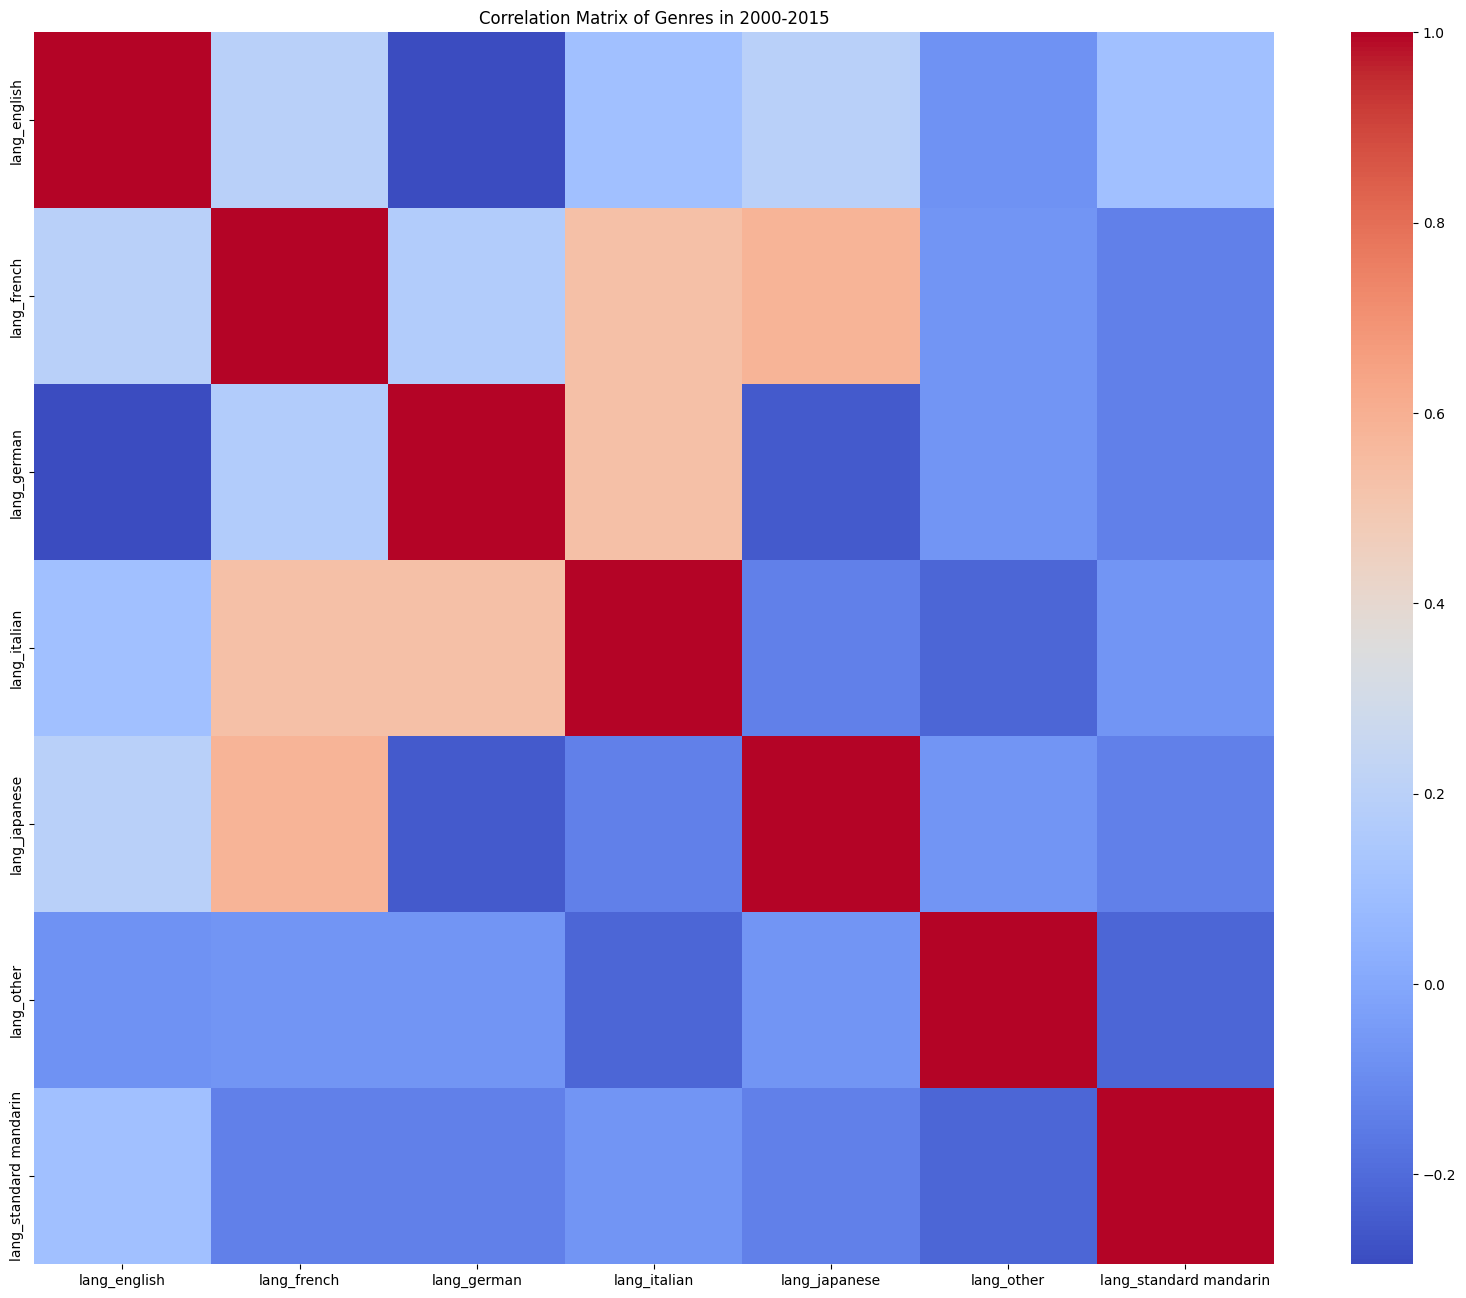

In [208]:
corr_matrix_top_(periods[4],df_period4,"lang_")

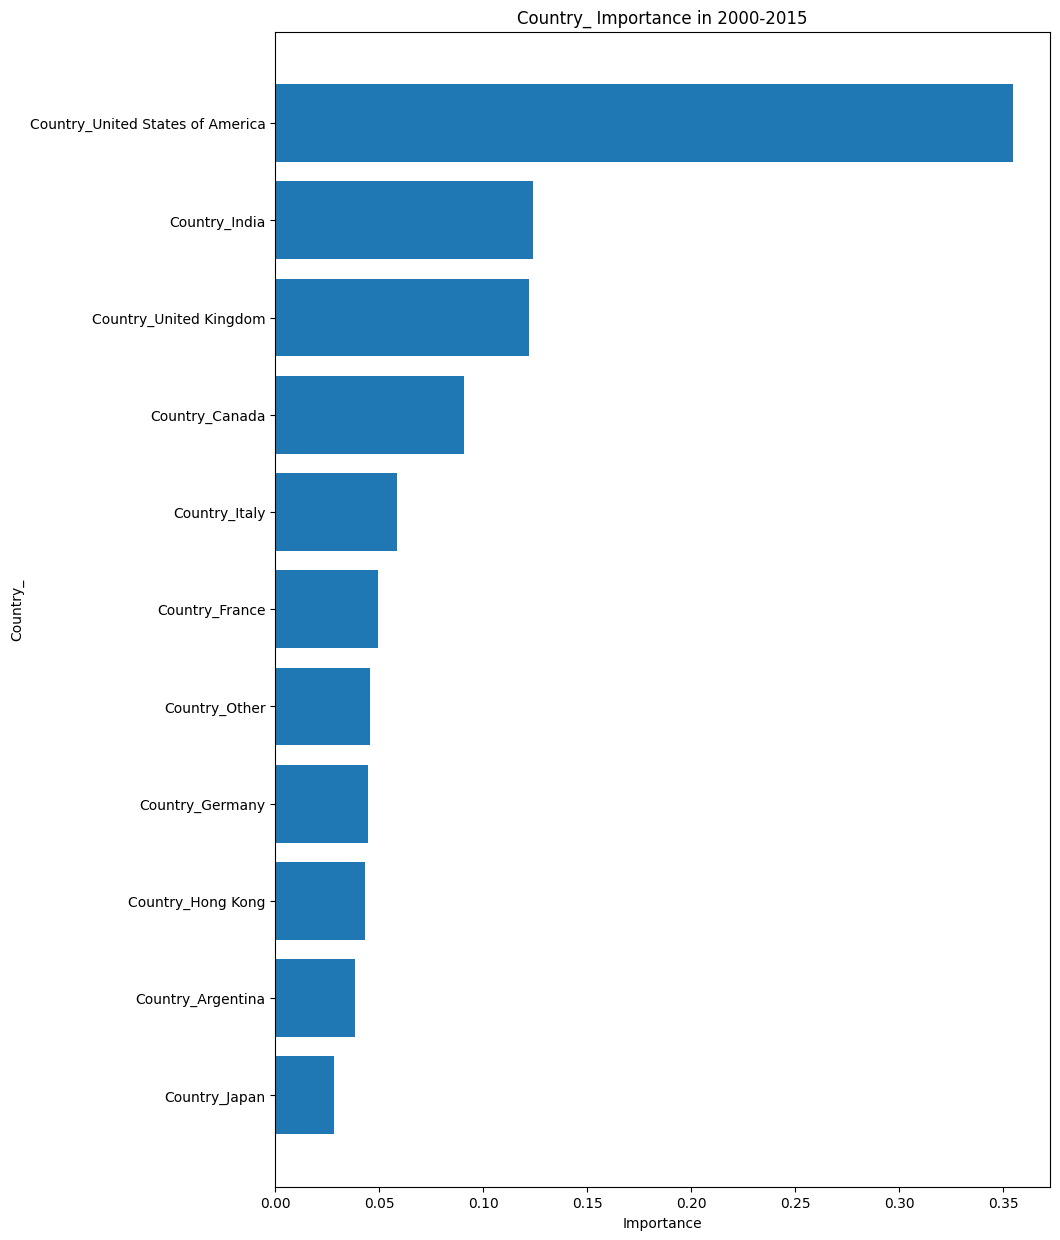

(6, 6)


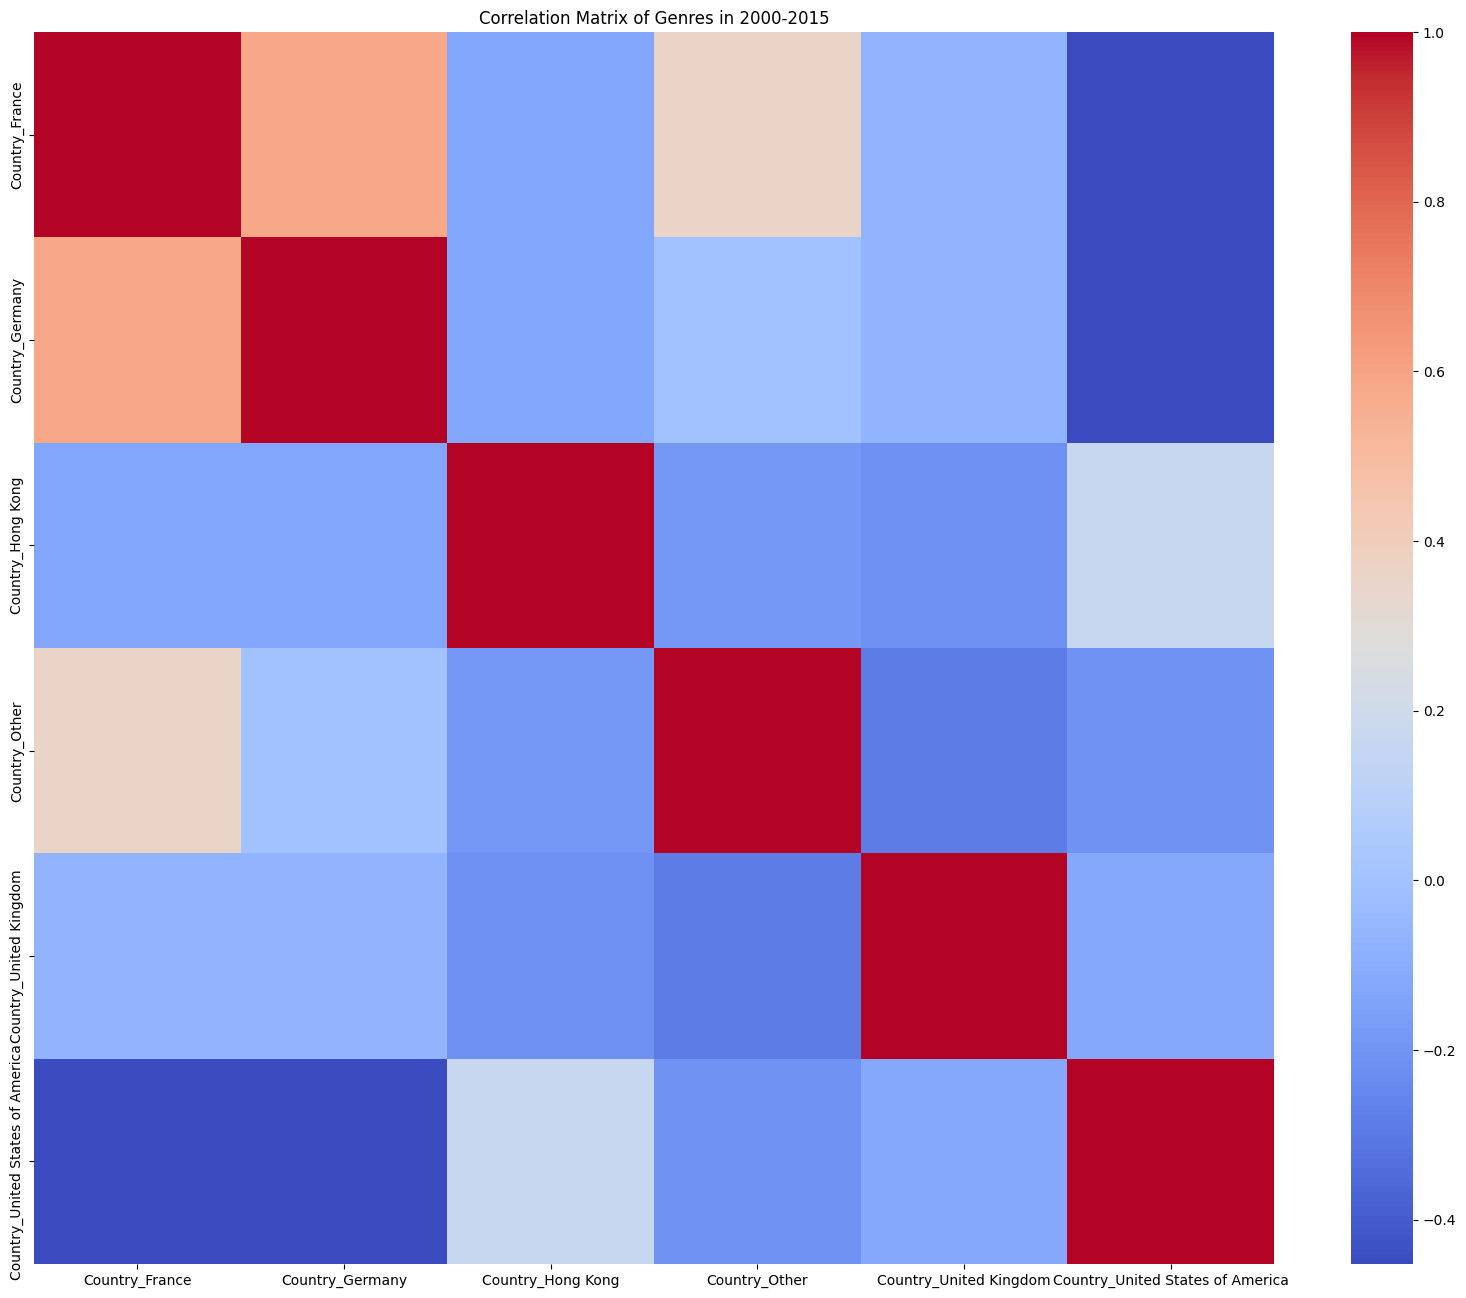

In [235]:
plot_feature_importance('2000-2015',df_period4,'Country_')
corr_matrix_top_(periods[4],df_period4,"Country_")